In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-posthocs

In [ ]:
import pandas as pd
import os

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from google.colab import drive
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.utils import resample
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

BOX-PLOTS

CSV usado: /content/drive/MyDrive/artigoI2MTC2026/aggregated_results/all_metrics_m4.csv

Coluna de método detectada: MethodCode
Métodos únicos detectados no arquivo geral: ['bootstrap', 'bootstrap_f', 'cqr_xgb', 'enbpi_xgb', 'full_conformal', 'full_conformal_f', 'split_conformal', 't_student']


/tmp/ipython-input-446619854.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap(cmap_name, max(n, 3))


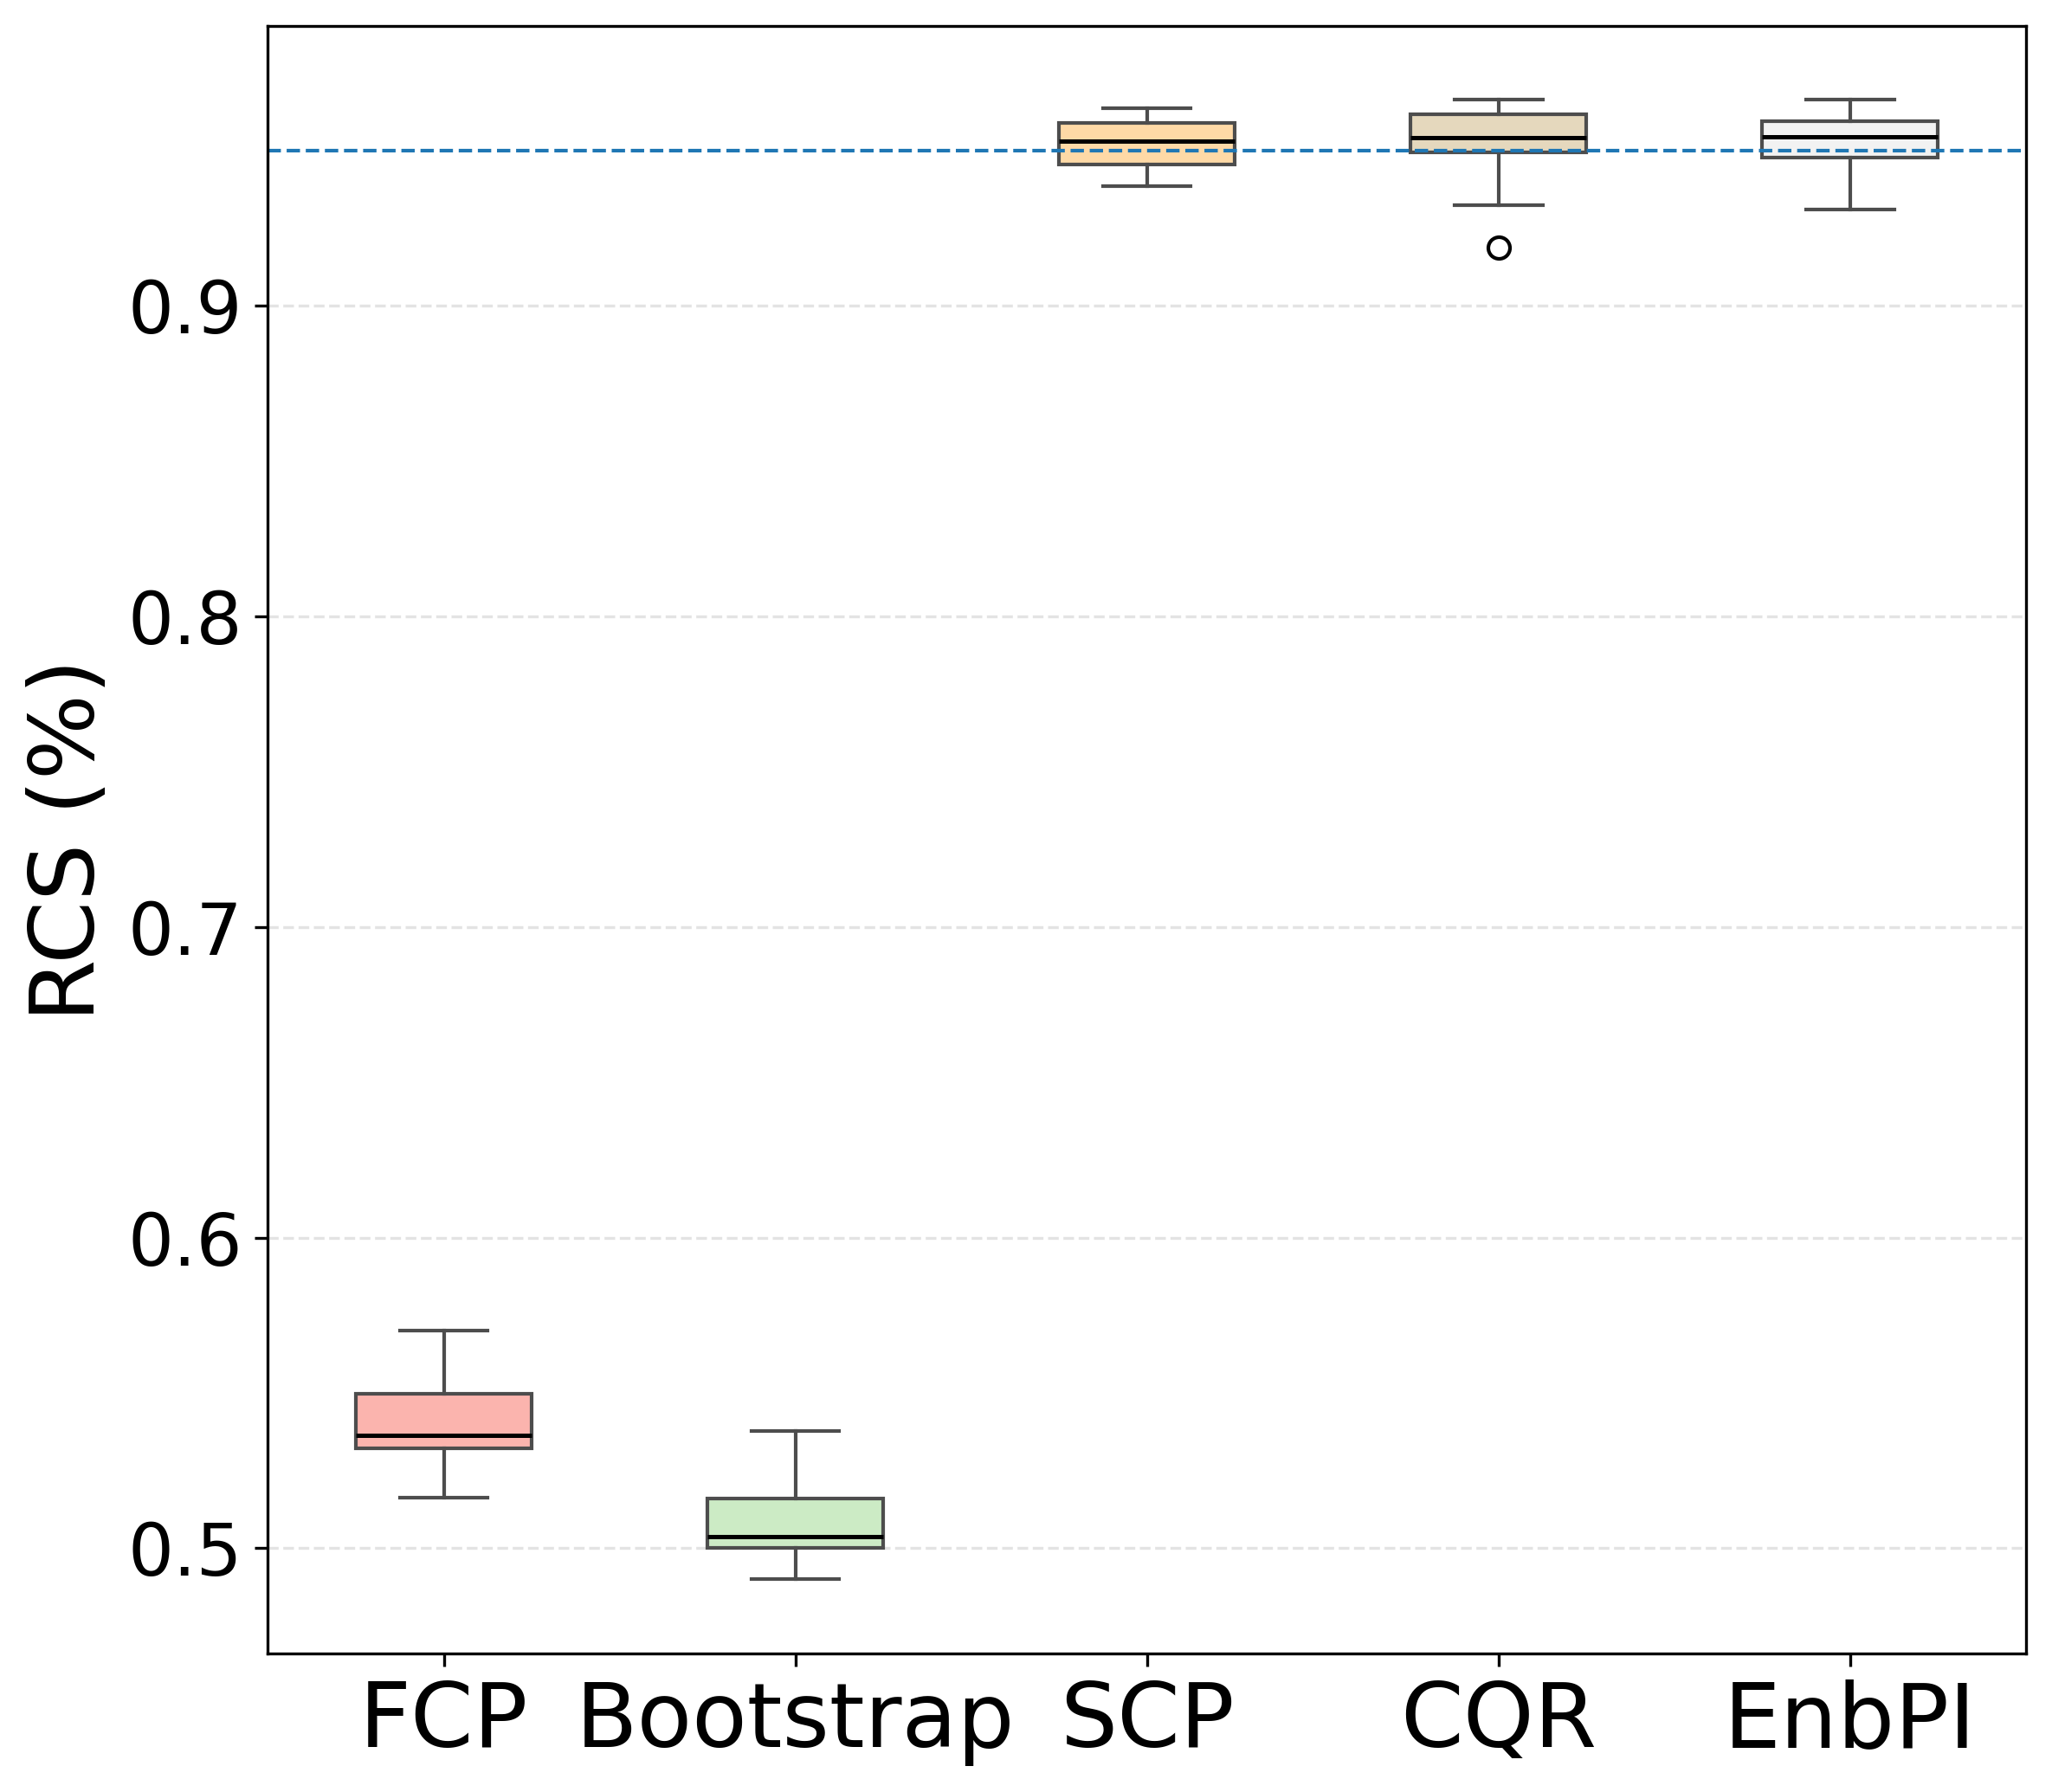

[OK] salvo: /content/drive/MyDrive/artigoI2MTC2026/aggregated_results/plots_pastel/boxplot_coverage_pastel.pdf


/tmp/ipython-input-446619854.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap(cmap_name, max(n, 3))


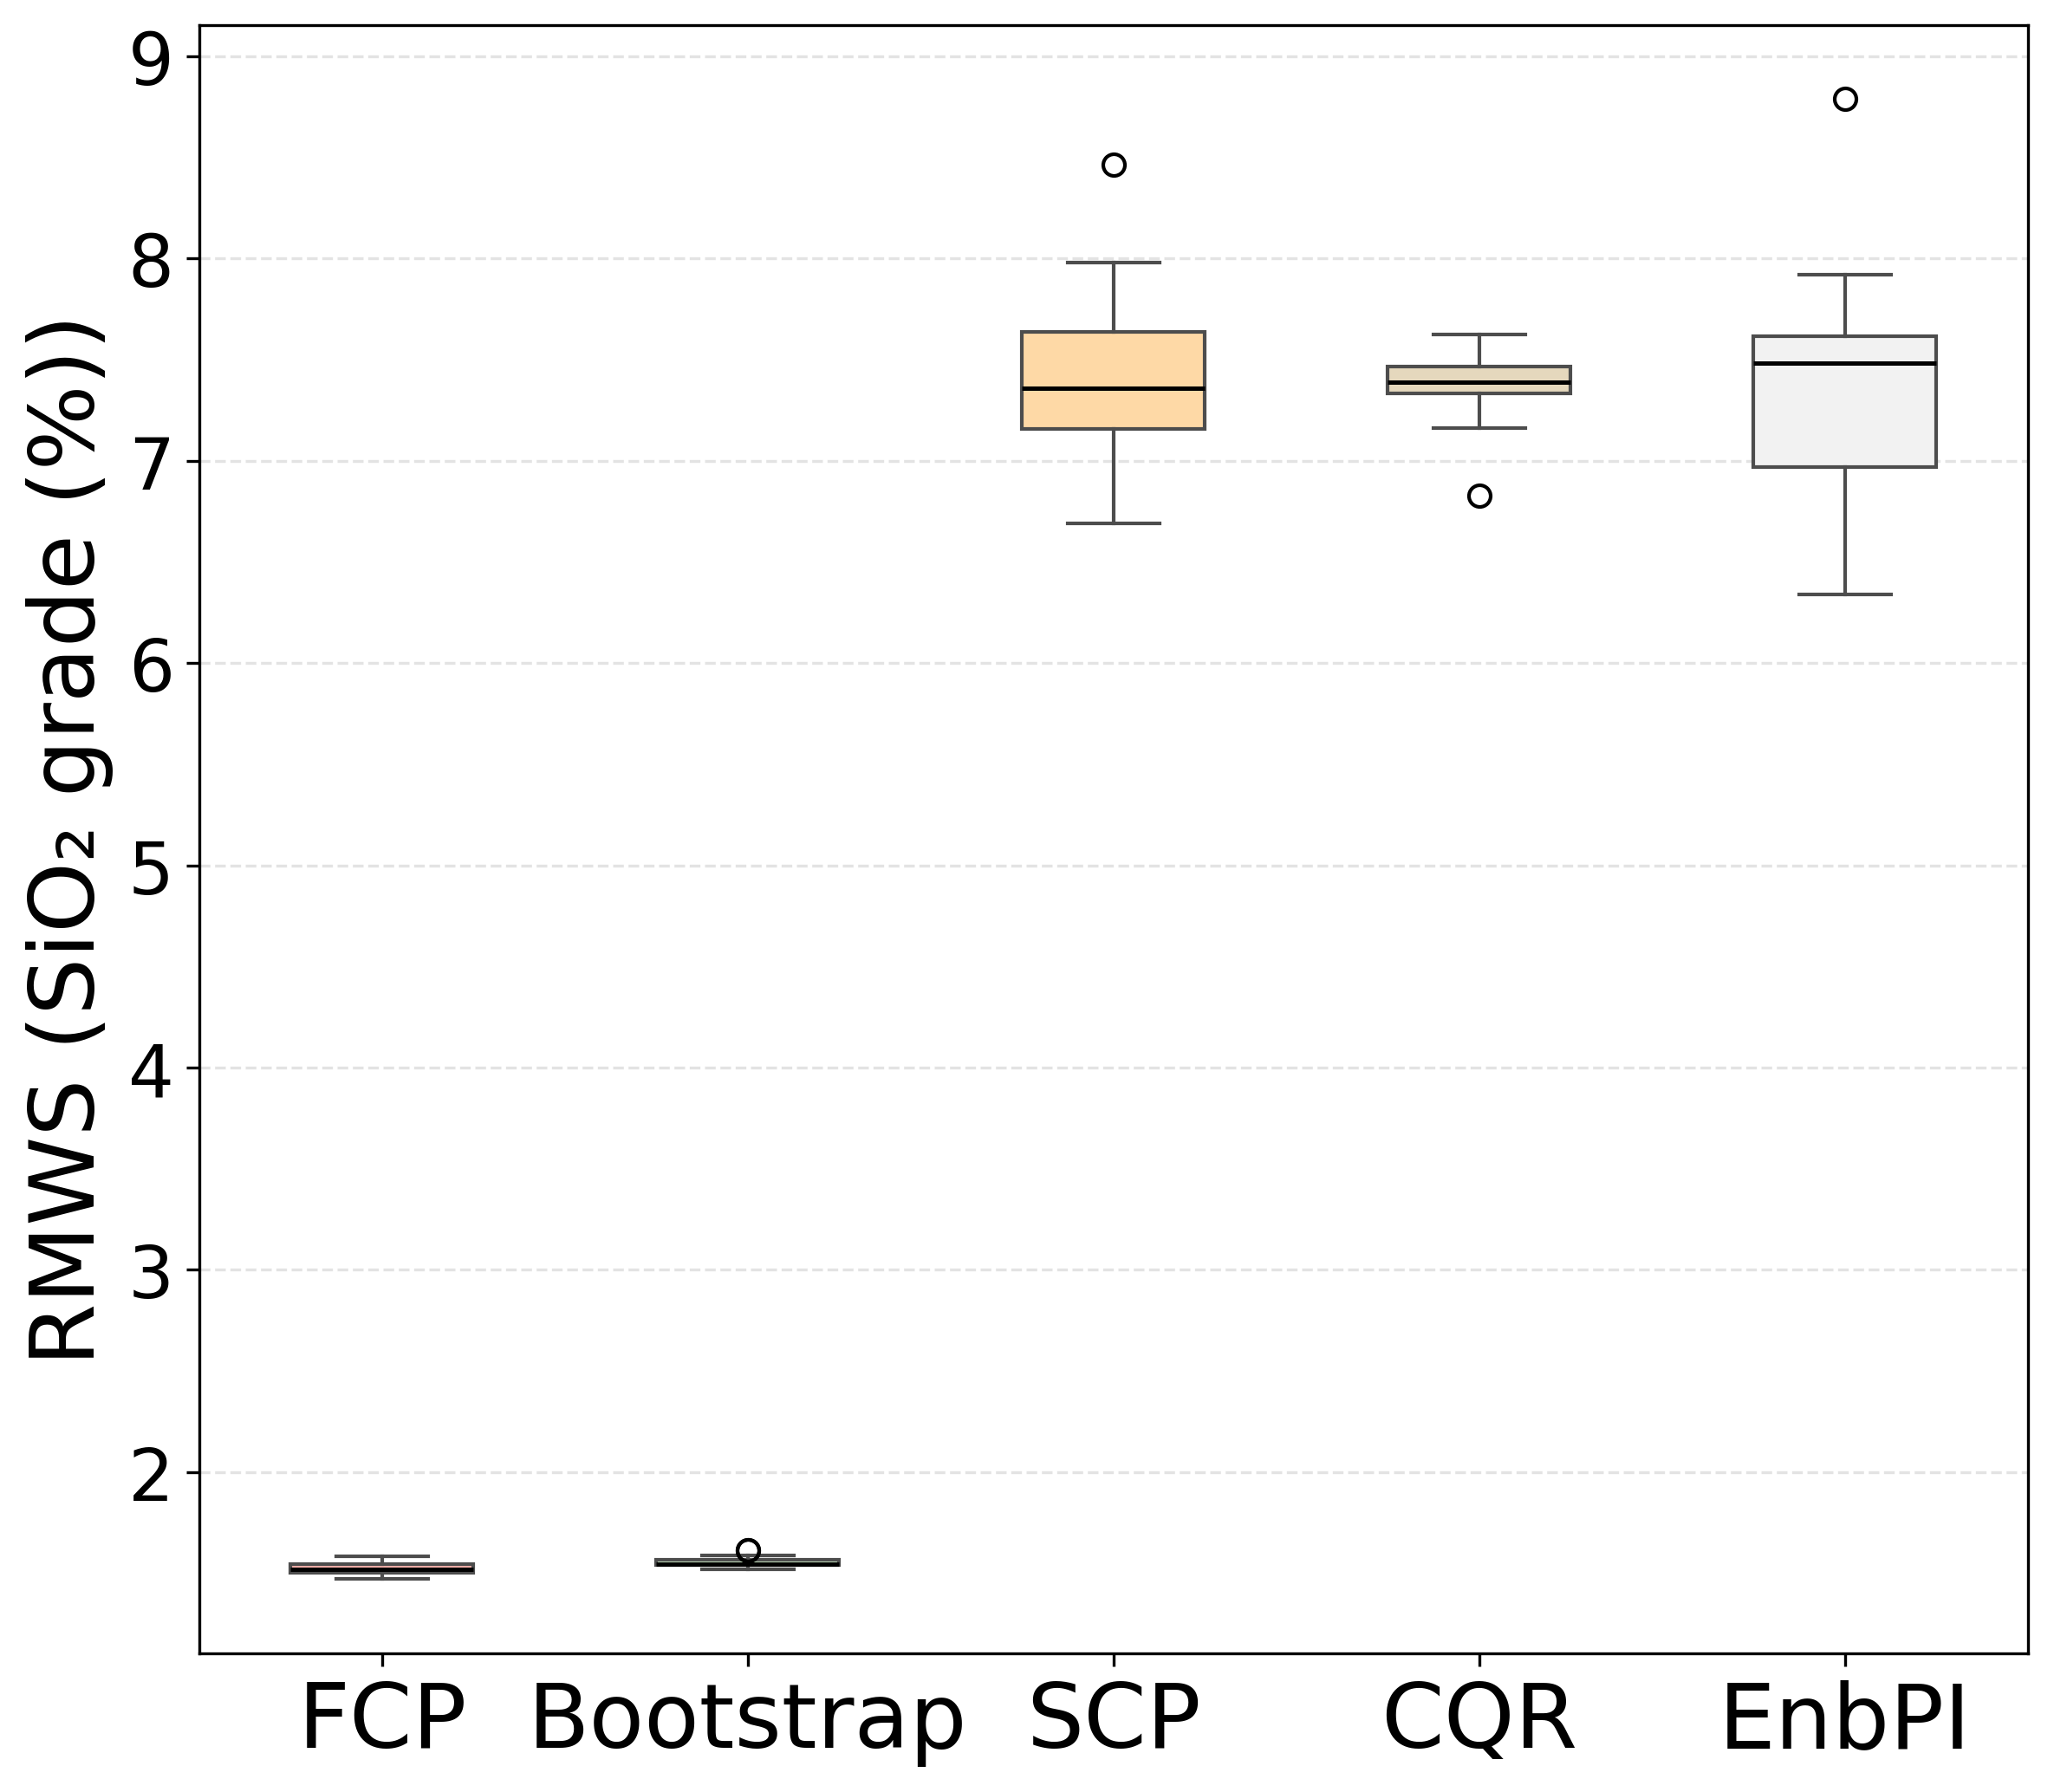

[OK] salvo: /content/drive/MyDrive/artigoI2MTC2026/aggregated_results/plots_pastel/boxplot_width_pastel.pdf


/tmp/ipython-input-446619854.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap(cmap_name, max(n, 3))


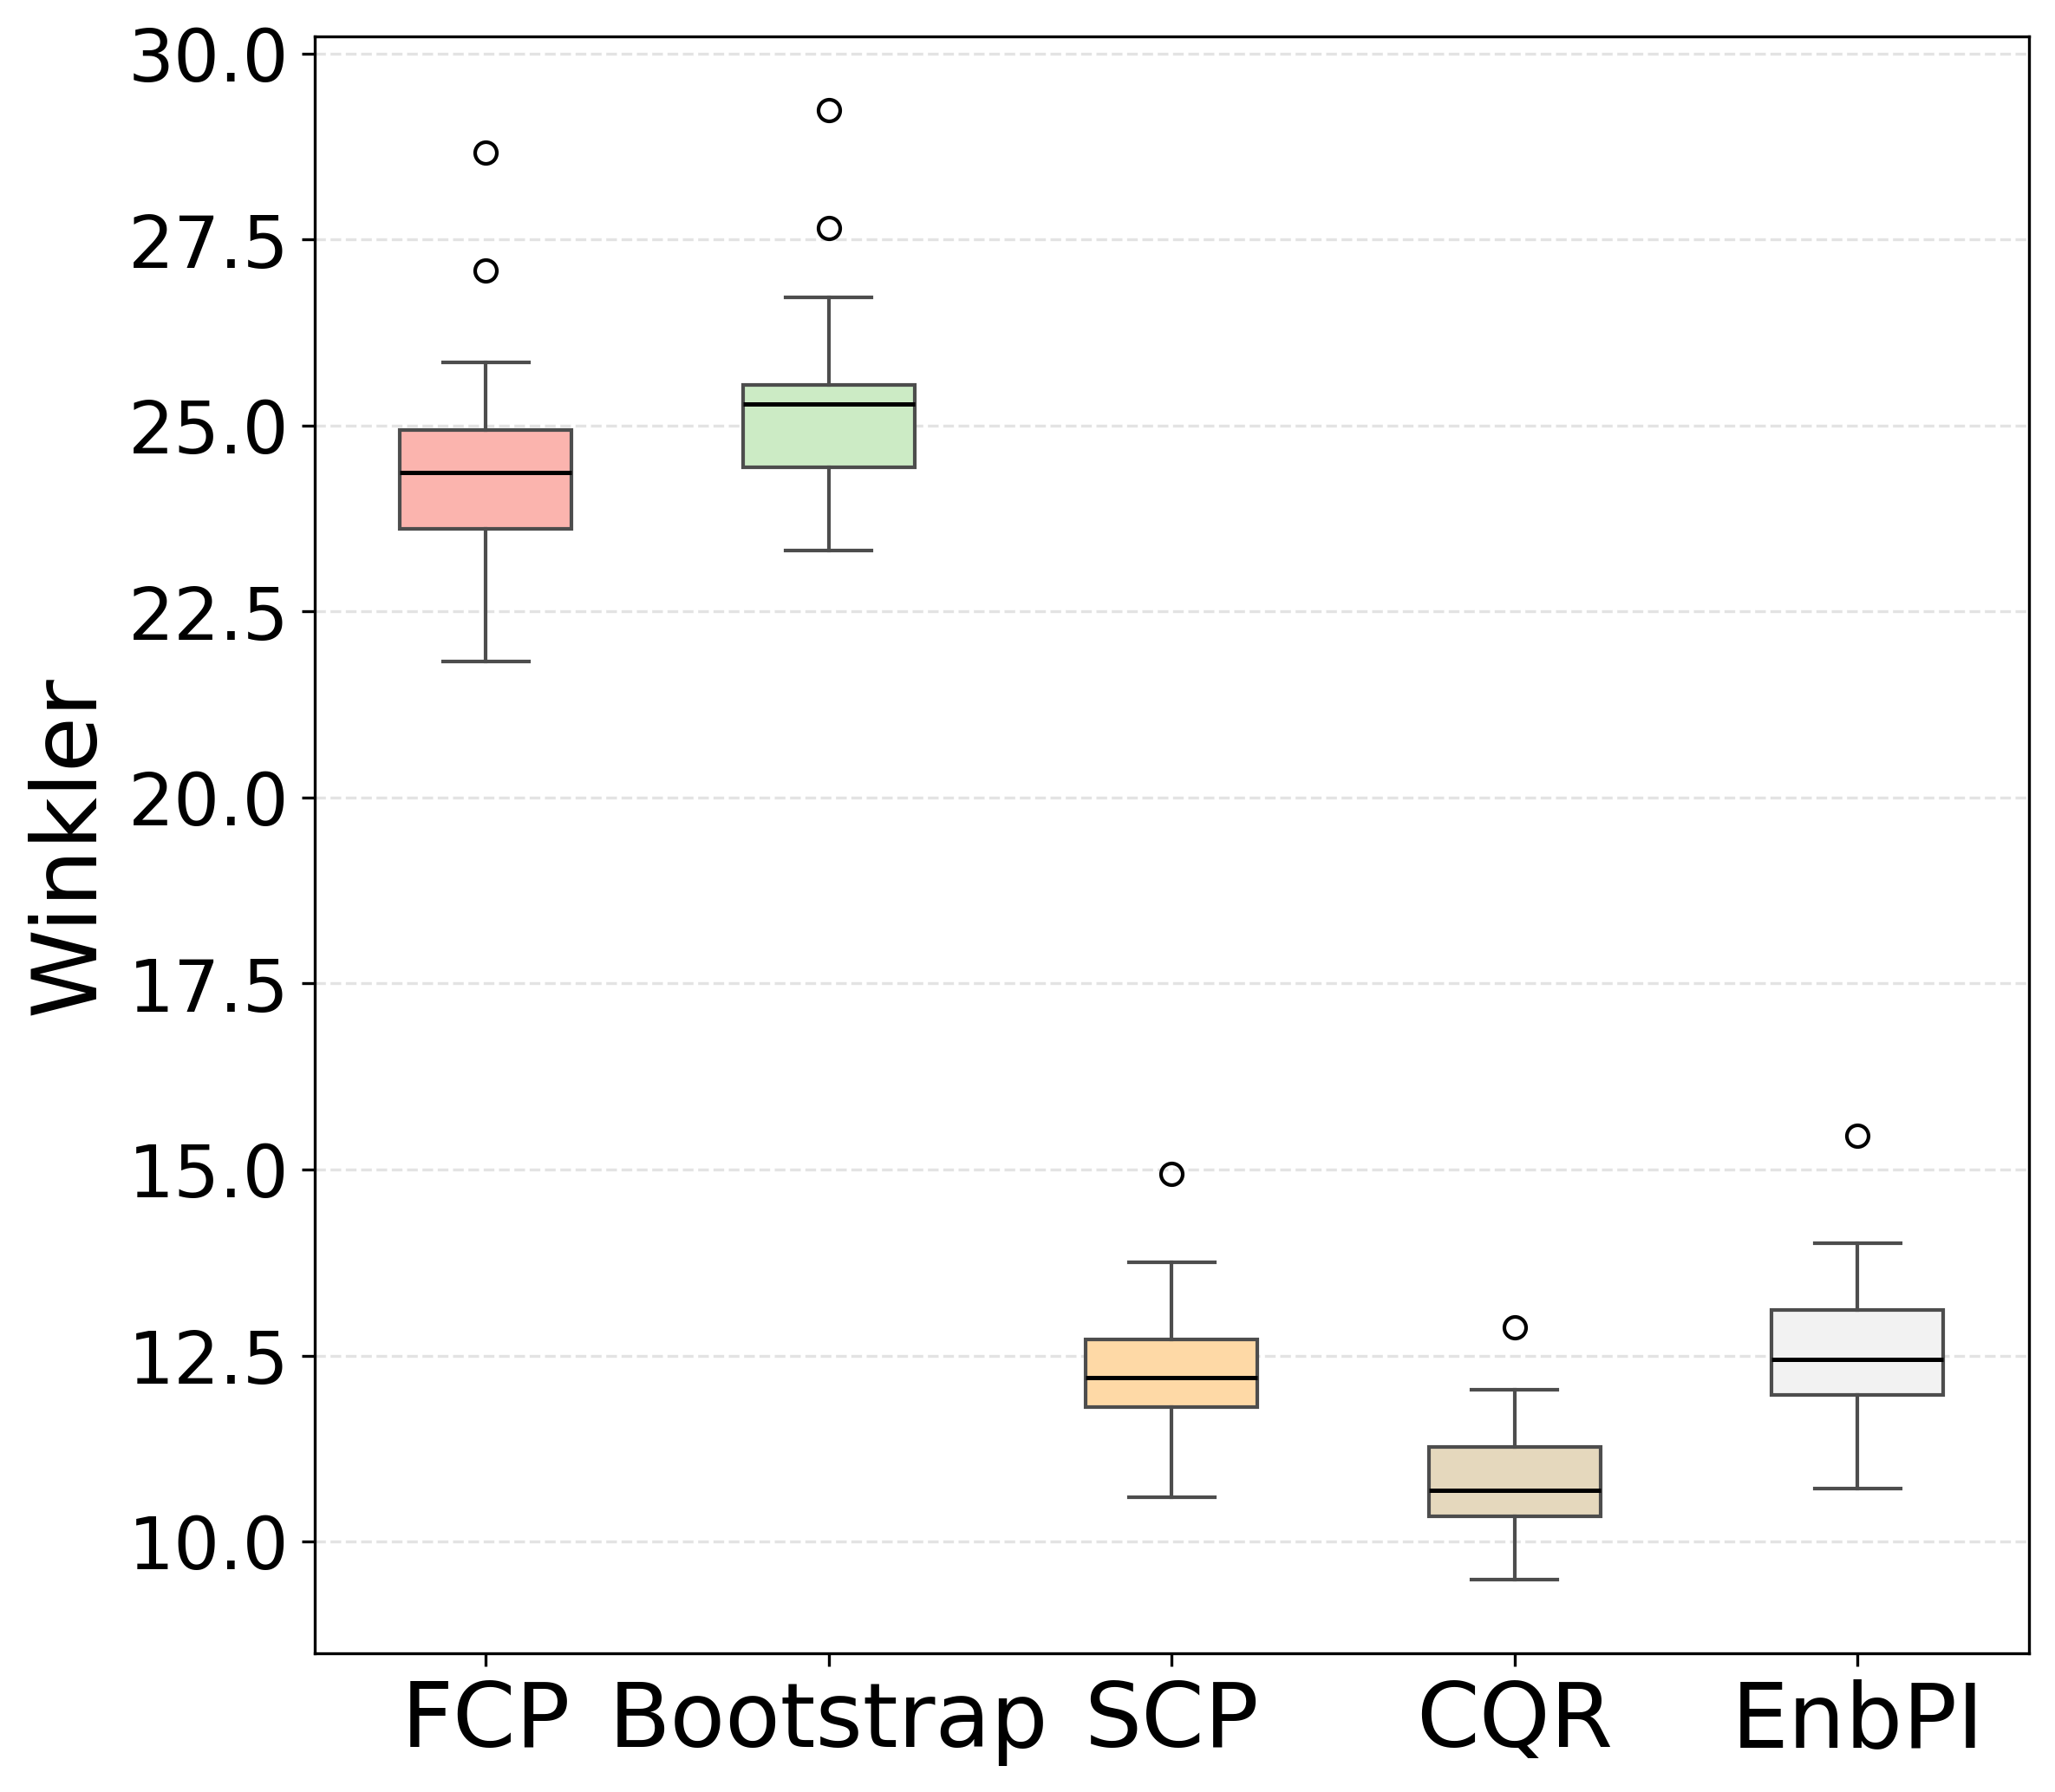

[OK] salvo: /content/drive/MyDrive/artigoI2MTC2026/aggregated_results/plots_pastel/boxplot_winkler_pastel.pdf


/tmp/ipython-input-446619854.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap(cmap_name, max(n, 3))


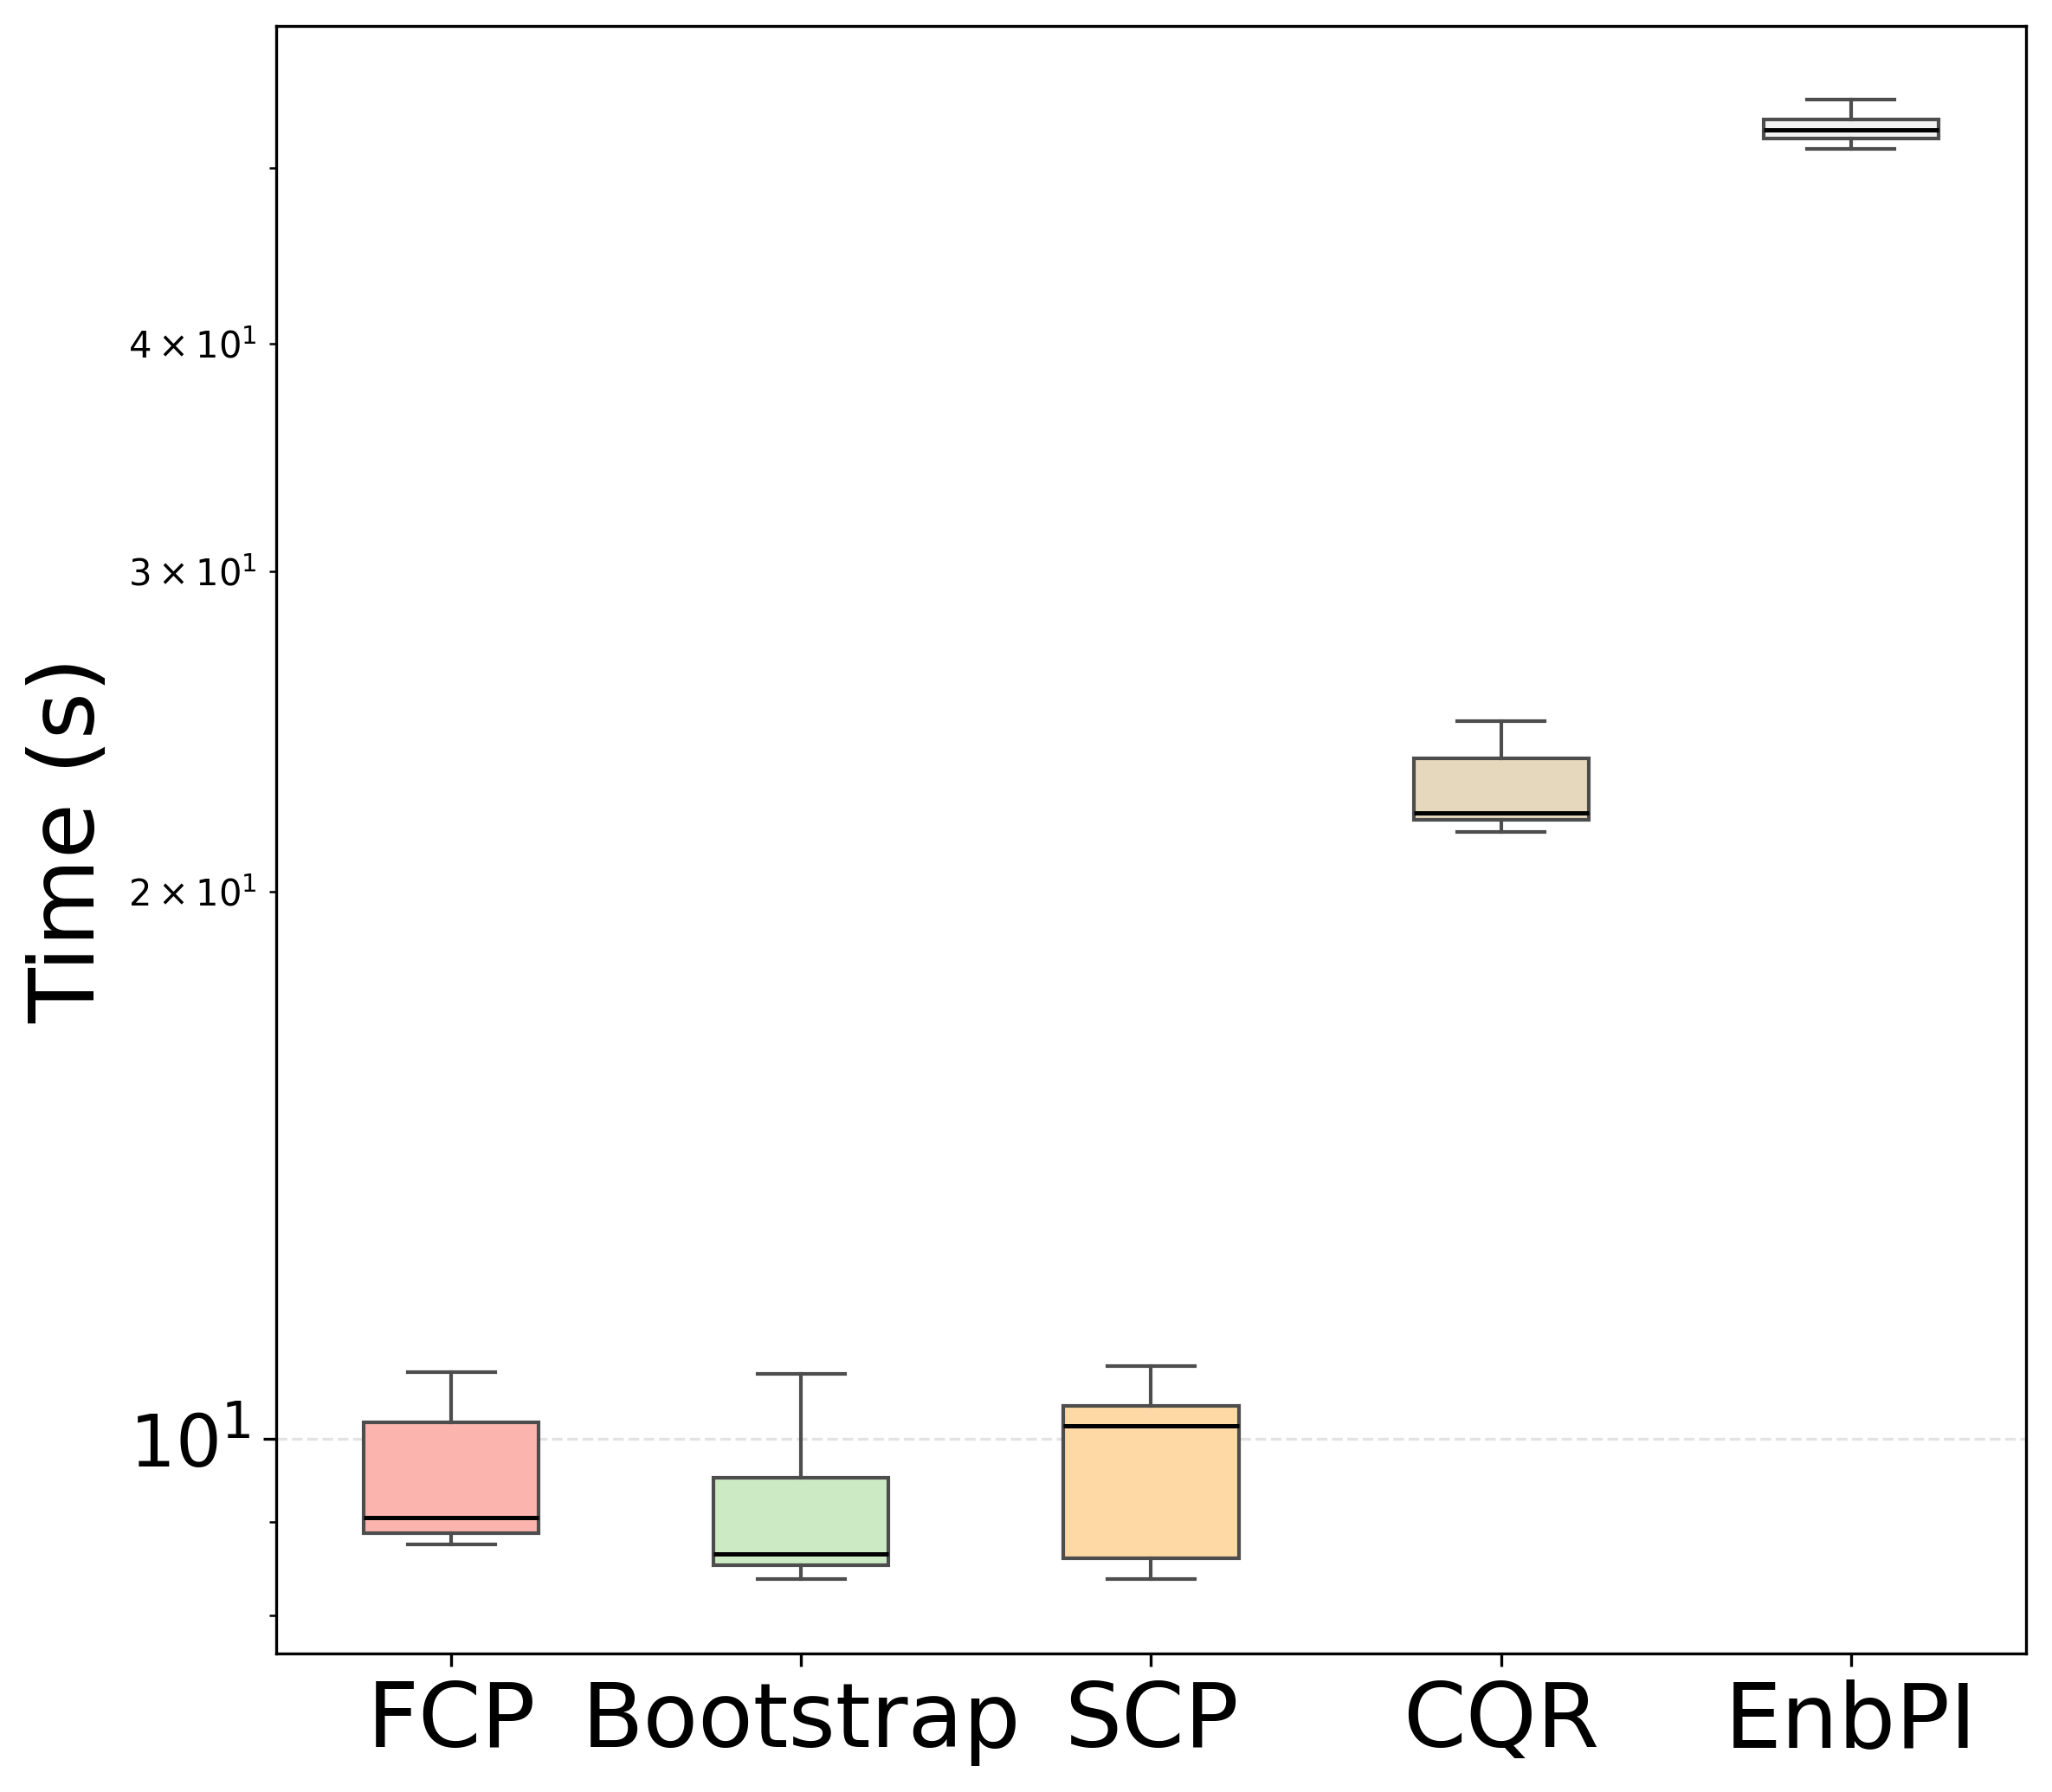

[OK] salvo: /content/drive/MyDrive/artigoI2MTC2026/aggregated_results/plots_pastel/boxplot_methodtime_s_pastel.pdf


In [11]:
# %% Colab: ler CSV, listar métricas e plotar boxplots individuais (pastel)

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ============ CONFIG ============
# tente ajustar estes caminhos primeiro; se não achar, vai abrir o upload
CANDIDATES = [
    # Path("/content/aggregated_results/all_metrics_m4.csv"),
    Path("/content/drive/MyDrive/artigoI2MTC2026/aggregated_results/all_metrics_m4.csv"),
    Path("aggregated_results/all_metrics_m4.csv"),
    # Path("all_metrics.csv"),
]

ALPHA = 0.05  #  linha alvo de cobertura

INCLUDE_MAP = {
    "full_conformal_f": "FCP",
    "bootstrap_f": "Bootstrap",
    "split_conformal": "SCP",
    "cqr_xgb": "CQR",
    "enbpi_xgb": "EnbPI",
}
# Rótulos bonitos
YLABELS = {
    "Coverage": "RCS (%)",
    "Width": "RMWS (SiO₂ grade (%))",
    "Winkler": "Winkler",
    "RMSE": "RMSE",
    "MethodTime_s": "Time (s)",
}

# ============ Helpers ============
def _find_csv():
    for p in CANDIDATES:
        if p.exists():
            return p
    try:
        from google.colab import files
        print("→ CSV não encontrado nos caminhos padrões. Selecione seu all_metrics.csv para upload:")
        uploaded = files.upload()
        for name in uploaded.keys():
            if name.lower().endswith(".csv"):
                return Path(name)
    except Exception as e:
        print("Upload não disponível (fora do Colab?). Erro:", e)
    raise FileNotFoundError("CSV não encontrado. Ajuste CANDIDATES ou faça upload no Colab.")

def detect_method_col(df: pd.DataFrame) -> str:
    """Prefere códigos (MethodCode). Cai para rótulos se não houver."""
    if "MethodCode" in df.columns: return "MethodCode"
    if "Unnamed: 0" in df.columns: return "Unnamed: 0"
    if "Method" in df.columns:     return "Method"
    if "index" in df.columns:
        df.rename(columns={"index": "Method"}, inplace=True)
        return "Method"
    return df.columns[0]

def list_available_metrics(df: pd.DataFrame) -> list[str]:
    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
    skip = {"run_id"}  # não é métrica
    return [c for c in numeric_cols if c not in skip]

def safe_name(s: str) -> str:
    return (s.replace(" ", "_").replace("/", "_").replace("%", "pct")
              .replace("(", "").replace(")", "").lower())

def pastel_colors(n: int, cmap_name: str = "Pastel1"):
    cmap = matplotlib.cm.get_cmap(cmap_name, max(n, 3))
    return [cmap(i) for i in range(n)]

def _boxplot_with_version(ax, data, labels, **kwargs):
    """Compatível com Matplotlib <3.9 (labels) e ≥3.9 (tick_labels)."""
    major, minor, *_ = [int(x) for x in matplotlib.__version__.split(".")]
    use_tick = (major > 3) or (major == 3 and minor >= 9)
    param = {"tick_labels" if use_tick else "labels": labels}
    return ax.boxplot(data, **param, **kwargs)

def prepare_series(df, method_col, metric, include_map):
    """
    Mantém apenas os métodos declarados em include_map (na ordem declarada).
    Se method_col for 'MethodCode', filtramos por códigos; caso contrário,
    tentamos casar por rótulos.
    """
    present = set(map(str, df[method_col].unique()))
    codes_in_order = list(include_map.keys())

    series, labels = [], []

    if method_col == "MethodCode":
        missing = [c for c in codes_in_order if c not in present]
        if missing:
            print("[WARN] códigos ausentes no CSV:", missing)
        for code in codes_in_order:
            if code in present:
                arr = df.loc[df[method_col] == code, metric].dropna().values
                if arr.size:
                    series.append(arr)
                    labels.append(include_map[code])
    else:
        desired_labels = list(include_map.values())
        missing = [lab for lab in desired_labels if lab not in present]
        if missing:
            print("[WARN] rótulos ausentes no CSV:", missing)
        for code, label in include_map.items():
            if label in present:
                arr = df.loc[df[method_col] == label, metric].dropna().values
                if arr.size:
                    series.append(arr)
                    labels.append(label)

    return series, labels

def plot_metric(df, method_col, metric, out_dir: Path, logy=False, show=True):
    series, labels = prepare_series(df, method_col, metric, INCLUDE_MAP)
    if not series:
        print(f"[WARN] Métrica '{metric}' sem dados — pulando.")
        return None

    colors = pastel_colors(len(labels), "Pastel1")
    w = max(8, 0.8*len(labels))
    fig, ax = plt.subplots(figsize=(w, 7), dpi=300)

    # Gerando o boxplot
    bp = _boxplot_with_version(
        ax, series, labels,
        showfliers=True, patch_artist=True,
        boxprops=dict(linewidth=1.0, edgecolor="0.3"),
        whiskerprops=dict(linewidth=1.0, color="0.3"),
        capprops=dict(linewidth=1.0, color="0.3"),
        medianprops=dict(linewidth=1.2, color="black"),
    )

    for patch, c in zip(bp["boxes"], colors):
        patch.set_facecolor(c)

    if metric.lower() == "coverage":
        ax.axhline(1-ALPHA, linestyle="--", linewidth=1.0)

    if logy:
        ax.set_yscale("log")

    ax.grid(axis="y", linestyle="--", alpha=0.35)


    ax.set_ylabel(YLABELS.get(metric, metric), fontsize=25)  # Aumentando fonte do rótulo Y



    for t in ax.get_xticklabels():
        t.set_rotation(0)
        t.set_ha("center")
        t.set_fontsize(25)

    for t in ax.get_yticklabels():
        t.set_fontsize(20)

    fig.tight_layout()

    # Salvar em PDF
    out_path = out_dir / f"boxplot_{safe_name(metric)}_pastel.pdf"
    fig.savefig(out_path, format="pdf", bbox_inches="tight")

    if show:
        try:
            from IPython.display import display
            display(fig)
        except Exception:
            pass

    plt.close(fig)

    print(f"[OK] salvo: {out_path}")
    return out_path


# ============ Execução ============
csv_path = _find_csv()
print(f"CSV usado: {csv_path}")
df = pd.read_csv(csv_path)
method_col = detect_method_col(df)
available = list_available_metrics(df)

print("\nColuna de método detectada:", method_col)
print("Métodos únicos detectados no arquivo geral:", sorted(map(str, df[method_col].unique())))

# print("\n== Métricas disponíveis ==")
# for m in available:
#     print("-", m)

# Escolha aqui quais métricas quer plotar (deixe vazio para todas)
metrics_to_plot = [
"Coverage",
"Width",
"Winkler",
"MethodTime_s",
]  # ex.: ["Coverage", "Width"]

if not metrics_to_plot:
    metrics_to_plot = available

out_dir = csv_path.parent / "plots_pastel"
out_dir.mkdir(parents=True, exist_ok=True)

for metric in metrics_to_plot:
    logy = (metric == "MethodTime_s")  # log no tempo por método (ajuste se quiser)
    plot_metric(df, method_col, metric, out_dir, logy=logy, show=True)



SHAPIRO-WILK TEST para verificar a normalidade Dados de Cobertura


In [14]:
!pip -q install openpyxl


In [15]:
%pip install -q XlsxWriter openpyxl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 3.2 MB/s eta 0:00:00


In [16]:
%pip install -q scikit-posthocs


In [17]:
# ============================================
# Gera arquivos XLSX em formato "largo"
# - largura_results.xlsx  (Width)
# - cobertura_results.xlsx (Coverage)
# - todos_modelos_results.xlsx (abas por modelo)
# ============================================

import pandas as pd
import numpy as np
import re


CSV_PATH = csv_path

# Ordem preferida das colunas (métodos) caso existam
PREFERRED_METHODS = [

    "full_conformal_f",
    "bootstrap_f",
    "split_conformal",
    "cqr_xgb",
    "enbpi_xgb",
]


# ---------- HELPERS ----------
def sanitize_sheet_name(name: str) -> str:
    """Limpa nome de aba pro Excel (<=31 chars, sem caracteres inválidos)."""
    name = str(name)
    name = re.sub(r"[\[\]\:\*\?\/\\]", "-", name)
    return name[:31]

def order_methods(cols, preferred=PREFERRED_METHODS):
    """Coloca preferidos na frente e o resto em ordem alfabética."""

    cols = list(cols)
    ordered = [c for c in preferred if c in cols]
    rest = sorted([c for c in cols if c not in ordered])
    return ordered + rest

def make_wide(df, value_col):
    """
    Cria tabela larga:
    - linhas = repetições (Model × run_id/execution_time/fallback)
    - colunas = MethodCode
    - retorna DataFrame só com as colunas de métodos (como o exemplo do usuário)
    """
    assert {"MethodCode", value_col}.issubset(df.columns), f"Faltam colunas para {value_col}"

    # Garante coluna Model (se não houver)
    if "Model" not in df.columns:
        df = df.copy()
        df["Model"] = "MODEL"

    # Define chave de repetição
    if "run_id" in df.columns:
        run_key = "run_id"
    elif "execution_time" in df.columns:
        run_key = "execution_time"
    else:
        # fallback: índice sequencial por (Model, MethodCode)
        df = df.copy()
        df["__rep"] = df.groupby(["Model", "MethodCode"]).cumcount()
        run_key = "__rep"

    wide = (
        df.pivot_table(
            index=["Model", run_key],
            columns="MethodCode",
            values=value_col,
            aggfunc="mean"
        )
        .sort_index()
    )

    # Filtra as colunas, mantendo apenas os métodos que estão em PREFERRED_METHODS e no DataFrame
    valid_methods = [method for method in PREFERRED_METHODS if method in wide.columns]

    # Garante que apenas as colunas válidas estão presentes
    wide = wide[valid_methods]

    # Reordena as colunas conforme a lista preferida
    wide = wide[valid_methods]  # Aqui não precisamos mais de `sorted`, pois já filtramos corretamente

    # Remove as colunas de índice (fica igual ao exemplo: só métodos, linhas numéricas)
    wide_out = wide.reset_index(drop=True)
    return wide_out




# ---------- 1) LER E PREPARAR CSV ----------
df = pd.read_csv(CSV_PATH)

# Limpeza básica
df.columns = [c.strip() for c in df.columns]
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Checagens mínimas
for col in ["MethodCode", "Coverage", "Width"]:
    if col not in df.columns:
        raise ValueError(f"Coluna obrigatória ausente no CSV: {col}")

# Tipos numéricos
df["Coverage"] = pd.to_numeric(df["Coverage"], errors="coerce")
df["Width"]    = pd.to_numeric(df["Width"],    errors="coerce")

# Remove linhas sem método
df = df.dropna(subset=["MethodCode"])

# ---------- 2) TABELAS LARGAS GLOBAIS ----------
largura_wide   = make_wide(df, "Width")
cobertura_wide = make_wide(df, "Coverage")

# ---------- 3) SALVAR XLSX (LARGURA e COBERTURA) ----------
largura_xlsx   = "/content/largura_results.xlsx"
cobertura_xlsx = "/content/cobertura_results.xlsx"

with pd.ExcelWriter(largura_xlsx, engine="xlsxwriter") as writer:
    largura_wide.to_excel(writer, index=False, sheet_name="Largura")

with pd.ExcelWriter(cobertura_xlsx, engine="xlsxwriter") as writer:
    cobertura_wide.to_excel(writer, index=False, sheet_name="Cobertura")

print("Salvos:")
print(largura_xlsx)
print(cobertura_xlsx)

Salvos:
/content/largura_results.xlsx
/content/cobertura_results.xlsx


In [ ]:
### upload arquivo
from google.colab import files
uploaded = files.upload()

Saving cobertura_results.xlsx to cobertura_results.xlsx


In [18]:
df = pd.read_excel('cobertura_results.xlsx')
df

,full_conformal_f,bootstrap_f,split_conformal,cqr_xgb,enbpi_xgb
0,0.524500,0.498965,0.957902,0.953071,0.952381
1,0.549344,0.508627,0.953071,0.958592,0.954451
2,0.544513,0.491373,0.945480,0.964803,0.955832
3,0.533471,0.501035,0.944099,0.966184,0.948240
4,0.526570,0.507937,0.963423,0.950311,0.966184
5,0.536232,0.500345,0.953071,0.961353,0.962733
6,0.518288,0.501035,0.952381,0.932367,0.944790
7,0.561767,0.518979,0.958592,0.951691,0.962733
8,0.554865,0.517598,0.959972,0.943409,0.955832
9,0.536232,0.525880,0.959972,0.959972,0.962043


In [19]:
from scipy.stats import shapiro

# Selecionar as colunas desejadas como uma lista
columns =  [

    "full_conformal_f",
    "bootstrap_f",
    "split_conformal",
    "cqr_xgb",
    "enbpi_xgb",
]

# Iterar sobre cada coluna e aplicar o teste Shapiro-Wilk
for column in columns:
    data = df[column]  # Selecionar os dados da coluna
    stat, p_value = shapiro(data)
    print(f"Coluna: {column}")
    print(f"Estatística do teste: {stat}")
    print(f"P-valor: {p_value}")
    if p_value > 0.05:
        print("Não rejeitamos a hipótese nula: os dados seguem uma distribuição normal.\n")
    else:
        print("Rejeitamos a hipótese nula: os dados não seguem uma distribuição normal.\n")

Coluna: full_conformal_f
Estatística do teste: 0.9579641429584971
P-valor: 0.5040243783775329
Não rejeitamos a hipótese nula: os dados seguem uma distribuição normal.

Coluna: bootstrap_f
Estatística do teste: 0.9097378245608306
P-valor: 0.06300648748283691
Não rejeitamos a hipótese nula: os dados seguem uma distribuição normal.

Coluna: split_conformal
Estatística do teste: 0.9387173240400162
P-valor: 0.22673636095139882
Não rejeitamos a hipótese nula: os dados seguem uma distribuição normal.

Coluna: cqr_xgb
Estatística do teste: 0.869079636716188
P-valor: 0.011319990463111383
Rejeitamos a hipótese nula: os dados não seguem uma distribuição normal.

Coluna: enbpi_xgb
Estatística do teste: 0.9518275103888891
P-valor: 0.39568546429529805
Não rejeitamos a hipótese nula: os dados seguem uma distribuição normal.



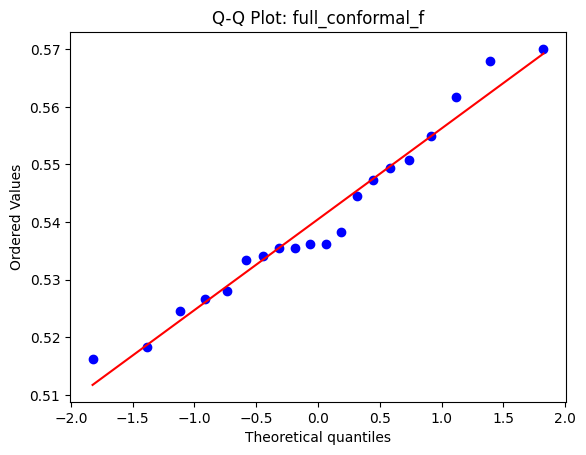

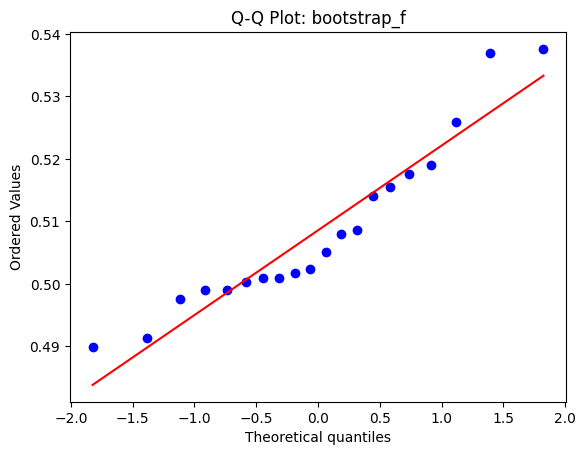

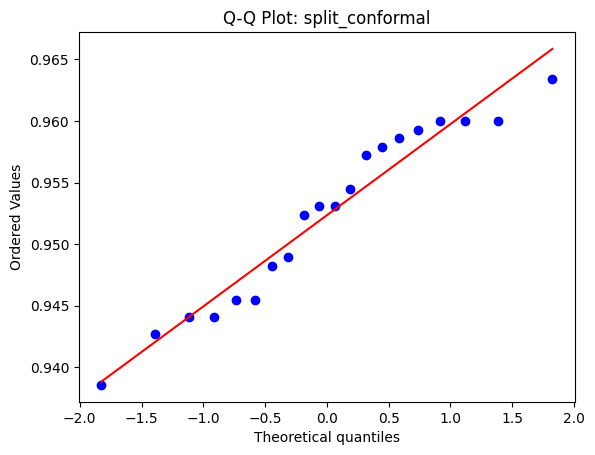

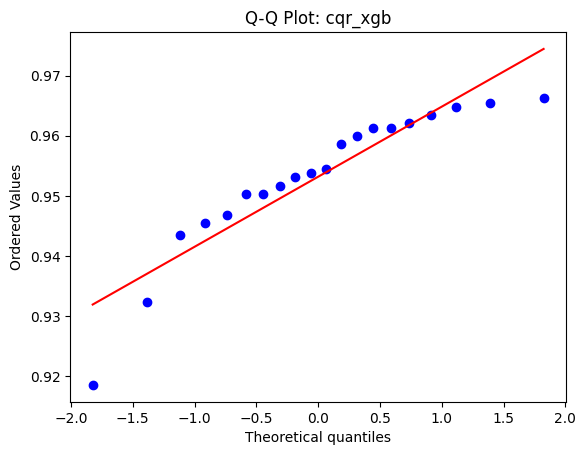

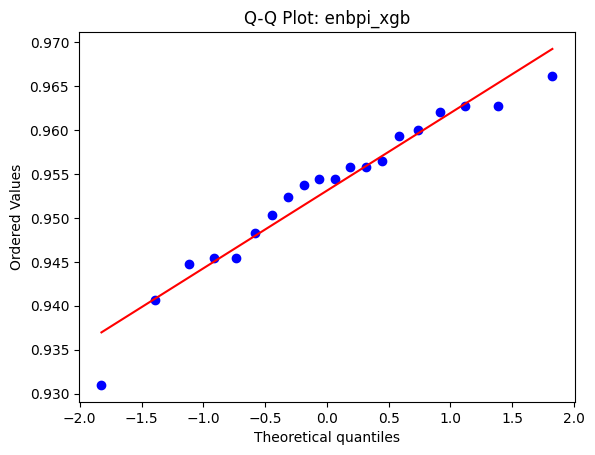

In [20]:
import matplotlib.pyplot as plt
import scipy.stats as stats

for column in columns:
    plt.figure()
    stats.probplot(df[column], plot=plt)
    plt.title(f'Q-Q Plot: {column}')
    plt.show()

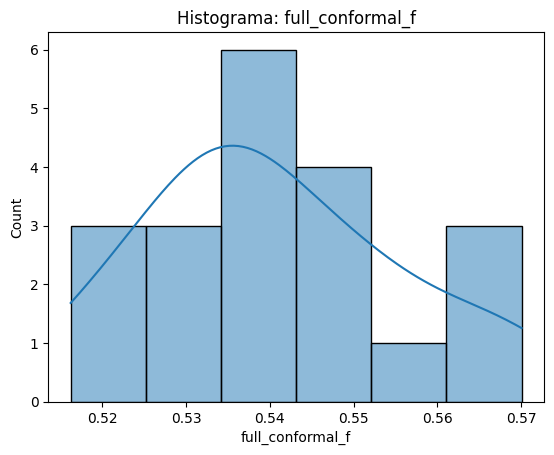

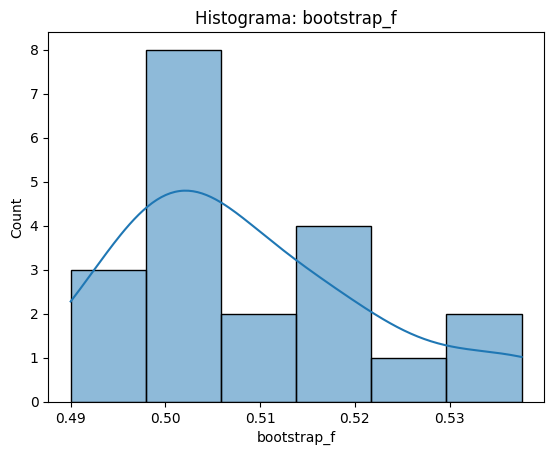

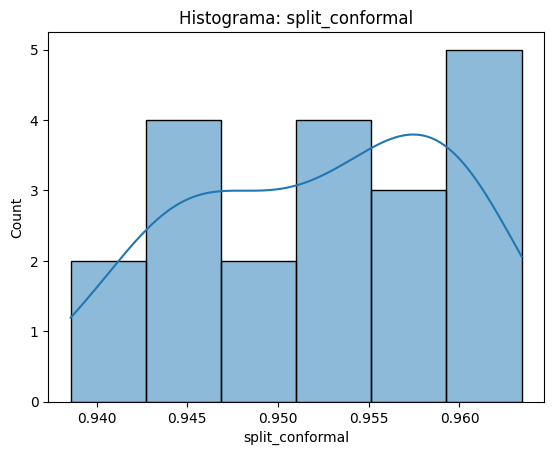

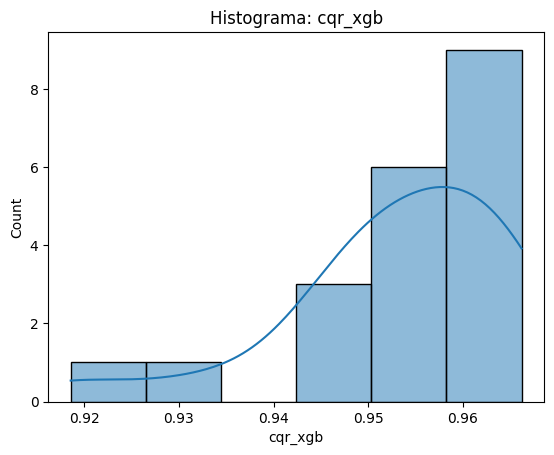

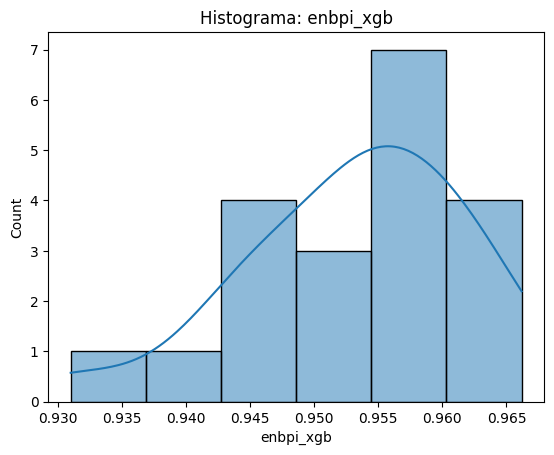

In [ ]:
# Exemplo: Teste de normalidade + histograma
import seaborn as sns
for column in columns:
    sns.histplot(df[column], kde=True)
    plt.title(f'Histograma: {column}')
    plt.show()

O Teste de Kruskal-Wallis: pra determina se há diferenças significativas entre os grupos. E o Teste de Dunn: Pra identificar quais grupos específicos apresentam diferenças significativas.  O ajuste de Bonferroni é usado para evitar falsos positivos.

In [ ]:
import pandas as pd
from scipy.stats import kruskal
import scikit_posthocs as sp

# Supondo que você tenha carregado seus dados no DataFrame `df`
# Certifique-se de que as colunas correspondem aos grupos mencionados
columns =  [

    "full_conformal_f",
    "bootstrap_f",
    # "bootstrap",
    "split_conformal",
    "cqr_xgb",
    "enbpi_xgb",
]

data = df[columns]

# Separar os valores de cada grupo
bootstrap = data['bootstrap_f']
cqr_xgb = data['cqr_xgb']
full_conformal = data['full_conformal_f']
split_conformal = data['split_conformal']
enbpi_xgb = data['enbpi_xgb']


# Aplicar o teste de Kruskal-Wallis
stat, p_value = kruskal(cqr_xgb,full_conformal,bootstrap,split_conformal,enbpi_xgb)
print(f"Estatística do teste: {stat}")
print(f"P-valor: {p_value}")

if p_value < 0.05:
    print("Rejeitamos a hipótese nula: pelo menos um dos grupos é diferente.")
else:
    print("Não rejeitamos a hipótese nula: todos os grupos têm distribuições semelhantes.")

# Organizar os dados no formato longo para o teste de Dunn
data_long = pd.melt(data.reset_index(), id_vars=['index'], value_vars=columns)
data_long.columns = ['Index', 'Group', 'Value']

# Verificar se as colunas foram configuradas corretamente
assert 'Value' in data_long.columns, "A coluna 'Value' não está no DataFrame."
assert 'Group' in data_long.columns, "A coluna 'Group' não está no DataFrame."

# Aplicar o teste de Dunn com ajuste Bonferroni
posthoc = sp.posthoc_dunn(data_long, val_col='Value', group_col='Group', p_adjust='bonferroni')

print("\nResultados do teste de Dunn (pós-hoc):")
print(posthoc)

Estatística do teste: 72.83358415841582
P-valor: 5.720772824446498e-15
Rejeitamos a hipótese nula: pelo menos um dos grupos é diferente.

Resultados do teste de Dunn (pós-hoc):
                  bootstrap_f       cqr_xgb     enbpi_xgb  full_conformal_f  \
bootstrap_f          1.000000  2.121023e-05  9.084961e-06      1.000000e+00   
cqr_xgb              0.000021  1.000000e+00  1.000000e+00      2.325769e-08   
enbpi_xgb            0.000009  1.000000e+00  1.000000e+00      8.138700e-09   
full_conformal_f     1.000000  2.325769e-08  8.138700e-09      1.000000e+00   
split_conformal      0.000012  1.000000e+00  1.000000e+00      1.185090e-08   

                  split_conformal  
bootstrap_f          1.231268e-05  
cqr_xgb              1.000000e+00  
enbpi_xgb            1.000000e+00  
full_conformal_f     1.185090e-08  
split_conformal      1.000000e+00  


In [ ]:
from scipy.stats import kruskal
import scikit_posthocs as sp

# Tamanho do efeito para Kruskal-Wallis (eta-squared)
H = 71.01
n = df.shape[0]  # Substitua pelo tamanho da amostra
eta2 = H / (n - 1)
print(f"Tamanho do efeito (η²): {eta2}")

Tamanho do efeito (η²): 3.737368421052632


SHAPIRO-WILK TEST para verificar a normalidade Dados de Largura

In [ ]:
### upload arquivo
from google.colab import files
uploaded = files.upload()

Saving largura_results.xlsx to largura_results.xlsx


In [ ]:
df = pd.read_excel('largura_results.xlsx')
df

,full_conformal_f,bootstrap_f,split_conformal,cqr_xgb,enbpi_xgb
0,1.503961,1.544438,7.799316,7.339776,7.728393
1,1.563038,1.527964,7.398986,7.448694,7.568819
2,1.522886,1.542122,6.925624,7.624260,7.292071
3,1.506516,1.538284,7.328429,7.548885,6.955964
4,1.484700,1.541140,8.462650,7.309678,8.788312
5,1.549747,1.542676,7.210061,7.538674,7.666600
6,1.505358,1.563937,7.882163,7.162726,7.488999
7,1.582918,1.613725,7.250178,7.463454,7.393312
8,1.545683,1.546296,7.981950,7.335202,7.495738
9,1.501271,1.543157,7.621573,7.377138,7.759899


In [ ]:
from scipy.stats import shapiro

# Selecionar as colunas desejadas como uma lista
columns = columns =  [

    "full_conformal_f",
    "bootstrap_f",
    # "bootstrap",
    "split_conformal",
    "cqr_xgb",
    "enbpi_xgb",
]
# Iterar sobre cada coluna e aplicar o teste Shapiro-Wilk
for column in columns:
    data = df[column]  # Selecionar os dados da coluna
    stat, p_value = shapiro(data)
    print(f"Coluna: {column}")
    print(f"Estatística do teste: {stat}")
    print(f"P-valor: {p_value}")
    if p_value > 0.05:
        print("Não rejeitamos a hipótese nula: os dados seguem uma distribuição normal.\n")
    else:
        print("Rejeitamos a hipótese nula: os dados não seguem uma distribuição normal.\n")

Coluna: full_conformal_f
Estatística do teste: 0.9600198535876271
P-valor: 0.5442458420019654
Não rejeitamos a hipótese nula: os dados seguem uma distribuição normal.

Coluna: bootstrap_f
Estatística do teste: 0.852622521782584
P-valor: 0.005899717558255225
Rejeitamos a hipótese nula: os dados não seguem uma distribuição normal.

Coluna: split_conformal
Estatística do teste: 0.9700306588137253
P-valor: 0.7555217445713407
Não rejeitamos a hipótese nula: os dados seguem uma distribuição normal.

Coluna: cqr_xgb
Estatística do teste: 0.860496385660831
P-valor: 0.008032584671304395
Rejeitamos a hipótese nula: os dados não seguem uma distribuição normal.

Coluna: enbpi_xgb
Estatística do teste: 0.9450407253455598
P-valor: 0.298000668408799
Não rejeitamos a hipótese nula: os dados seguem uma distribuição normal.



O Teste de Kruskal-Wallis: pra determina se há diferenças significativas entre os grupos. E o Teste de Dunn: Pra identificar quais grupos específicos apresentam diferenças significativas.  O ajuste de Bonferroni é usado para evitar falsos positivos.

In [ ]:
import pandas as pd
from scipy.stats import kruskal
import scikit_posthocs as sp

# Supondo que você tenha carregado seus dados no DataFrame `df`
# Certifique-se de que as colunas correspondem aos grupos mencionados
columns = columns =  [
    "full_conformal_f",
    "bootstrap_f",
    # "bootstrap",
    "split_conformal",
    "cqr_xgb",
    "enbpi_xgb",
]
data = df[columns]

# Separar os valores de cada grupo
bootstrap = data['bootstrap_f']
cqr_xgb = data['cqr_xgb']
full_conformal = data['full_conformal_f']
split_conformal = data['split_conformal']
enbpi_xgb = data['enbpi_xgb']

# Aplicar o teste de Kruskal-Wallis
stat, p_value = kruskal(full_conformal,bootstrap,split_conformal,enbpi_xgb)
print(f"Estatística do teste: {stat}")
print(f"P-valor: {p_value}")

if p_value < 0.05:
    print("Rejeitamos a hipótese nula: pelo menos um dos grupos é diferente.")
else:
    print("Não rejeitamos a hipótese nula: todos os grupos têm distribuições semelhantes.")

# Organizar os dados no formato longo para o teste de Dunn
data_long = pd.melt(data.reset_index(), id_vars=['index'], value_vars=columns)
data_long.columns = ['Index', 'Group', 'Value']

# Verificar se as colunas foram configuradas corretamente
assert 'Value' in data_long.columns, "A coluna 'Value' não está no DataFrame."
assert 'Group' in data_long.columns, "A coluna 'Group' não está no DataFrame."

# Aplicar o teste de Dunn com ajuste Bonferroni
posthoc = sp.posthoc_dunn(data_long, val_col='Value', group_col='Group', p_adjust='bonferroni')

print("\nResultados do teste de Dunn (pós-hoc):")
print(posthoc)

Estatística do teste: 61.63296296296295
P-valor: 2.632092787051616e-13
Rejeitamos a hipótese nula: pelo menos um dos grupos é diferente.

Resultados do teste de Dunn (pós-hoc):
                  bootstrap_f       cqr_xgb     enbpi_xgb  full_conformal_f  \
bootstrap_f          1.000000  2.121023e-05  9.084961e-06      1.000000e+00   
cqr_xgb              0.000021  1.000000e+00  1.000000e+00      2.325769e-08   
enbpi_xgb            0.000009  1.000000e+00  1.000000e+00      8.138700e-09   
full_conformal_f     1.000000  2.325769e-08  8.138700e-09      1.000000e+00   
split_conformal      0.000012  1.000000e+00  1.000000e+00      1.185090e-08   

                  split_conformal  
bootstrap_f          1.231268e-05  
cqr_xgb              1.000000e+00  
enbpi_xgb            1.000000e+00  
full_conformal_f     1.185090e-08  
split_conformal      1.000000e+00  


Friedman e Nemenyi para analise de grupos de features

In [ ]:
%pip install autorank

  Preparing metadata (setup.py) ... done
  Created wheel for baycomp: filename=baycomp-1.0.3-py3-none-any.whl size=18027 sha256=11ad3e7d1fe9ee805221cda7105b2e810c803642f848d44ccfb9e55e71f73d7e
  Stored in directory: /root/.cache/pip/wheels/ff/39/6a/f87e05ad75b9d87f4eb262a897ec2fe3aab09449d13e3c3b2c
Successfully built baycomp


[GLOBAL MAE] blocos=80 × tratamentos=4 (m1, m2, m3, m4)
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column m1 (p=0.027272>=0.012500)
Rejecting null hypothesis that data is normal for column m2 (p=0.000198<0.012500)
Rejecting null hypothesis that data is normal for column m3 (p=0.000346<0.012500)
Rejecting null hypothesis that data is normal for column m4 (p=0.000661<0.012500)
Using Levene's test for homoscedacity of non-normal data.
Rejecting null hypothesis that all variances are equal (p=0.035674<0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
m1    1.3750  0.857285   0.03371 

/tmp/ipython-input-529662784.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

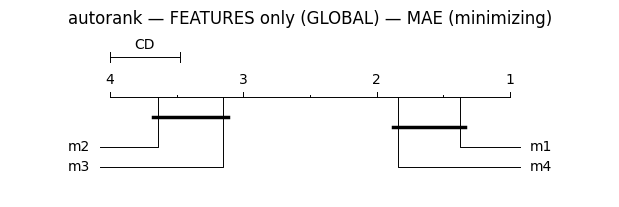

[RF MAE] runs=20 × tratamentos=4 (m1, m2, m3, m4)
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column m1 (p=0.545398>=0.012500)
Fail to reject null hypothesis that data is normal for column m2 (p=0.196569>=0.012500)
Fail to reject null hypothesis that data is normal for column m3 (p=0.422876>=0.012500)
Fail to reject null hypothesis that data is normal for column m4 (p=0.136114>=0.012500)
Using Bartlett's test for homoscedacity of normally distributed data
Fail to reject null hypothesis that all variances are equal (p=0.980023>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
m4  

/tmp/ipython-input-529662784.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

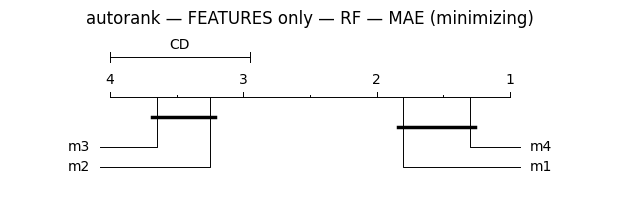

[XGB MAE] runs=20 × tratamentos=4 (m1, m2, m3, m4)
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column m1 (p=0.502666>=0.012500)
Fail to reject null hypothesis that data is normal for column m2 (p=0.465012>=0.012500)
Fail to reject null hypothesis that data is normal for column m3 (p=0.787525>=0.012500)
Fail to reject null hypothesis that data is normal for column m4 (p=0.724786>=0.012500)
Using Bartlett's test for homoscedacity of normally distributed data
Fail to reject null hypothesis that all variances are equal (p=0.986783>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
m1 

/tmp/ipython-input-529662784.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

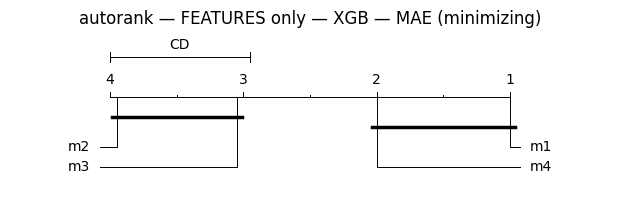

[LGBM MAE] runs=20 × tratamentos=4 (m1, m2, m3, m4)
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column m1 (p=0.729939>=0.012500)
Fail to reject null hypothesis that data is normal for column m2 (p=0.951796>=0.012500)
Fail to reject null hypothesis that data is normal for column m3 (p=0.775347>=0.012500)
Fail to reject null hypothesis that data is normal for column m4 (p=0.374978>=0.012500)
Using Bartlett's test for homoscedacity of normally distributed data
Fail to reject null hypothesis that all variances are equal (p=0.962439>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
m1

/tmp/ipython-input-529662784.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

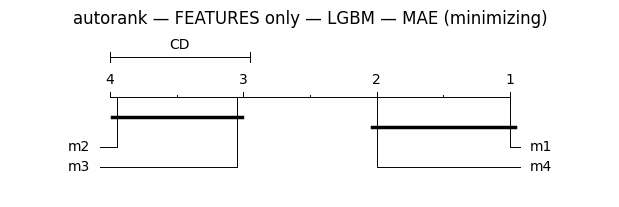

[MLP MAE] runs=20 × tratamentos=4 (m1, m2, m3, m4)
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column m1 (p=0.884807>=0.012500)
Rejecting null hypothesis that data is normal for column m2 (p=0.001333<0.012500)
Fail to reject null hypothesis that data is normal for column m3 (p=0.717832>=0.012500)
Fail to reject null hypothesis that data is normal for column m4 (p=0.782505>=0.012500)
Using Levene's test for homoscedacity of non-normal data.


/tmp/ipython-input-529662784.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Fail to reject null hypothesis that all variances are equal (p=0.156501>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000091)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
m1      1.70  0.924092  0.012447  0.904137  0.980479         0.0  negligible   
m4      2.05  0.933899  0.017967  0.903318  0.980438   -0.427984       small   
m3      2.85  0.952667  0.018124  0.911696  0.999495   -1.239703       large   
m2      3.40  0.960628  0.007631  0.945139  1.024386   -2.387023       large   

   effect_size_above magnitude_above  
m1               0.0      negligible  
m4         -0.427984           small  
m3         -0.701486          medium  
m2         -0.386128           small  
[MLP MAE] relatório: autorank_features_only_fixed/autoran

<Figure size 640x480 with 0 Axes>

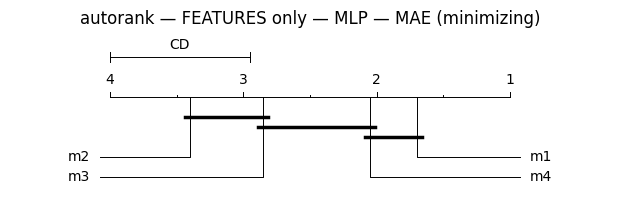

[GLOBAL RMSE] blocos=80 × tratamentos=4 (m1, m2, m3, m4)
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column m1 (p=0.914928>=0.012500)
Fail to reject null hypothesis that data is normal for column m2 (p=0.638981>=0.012500)
Fail to reject null hypothesis that data is normal for column m3 (p=0.204935>=0.012500)
Fail to reject null hypothesis that data is normal for column m4 (p=0.139180>=0.012500)
Using Bartlett's test for homoscedacity of normally distributed data
Fail to reject null hypothesis that all variances are equal (p=0.275118>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude 

/tmp/ipython-input-529662784.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

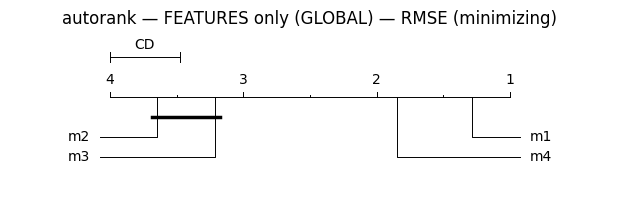

[RF RMSE] runs=20 × tratamentos=4 (m1, m2, m3, m4)
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column m1 (p=0.740389>=0.012500)
Fail to reject null hypothesis that data is normal for column m2 (p=0.651312>=0.012500)
Fail to reject null hypothesis that data is normal for column m3 (p=0.916068>=0.012500)
Fail to reject null hypothesis that data is normal for column m4 (p=0.460369>=0.012500)
Using Bartlett's test for homoscedacity of normally distributed data
Fail to reject null hypothesis that all variances are equal (p=0.978780>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
m1 

/tmp/ipython-input-529662784.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

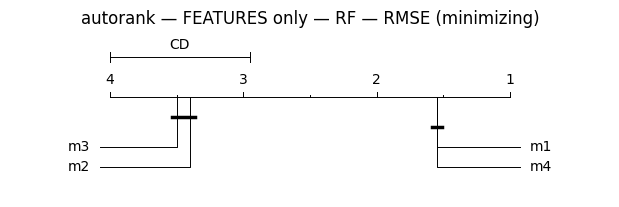

[XGB RMSE] runs=20 × tratamentos=4 (m1, m2, m3, m4)
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column m1 (p=0.911362>=0.012500)
Fail to reject null hypothesis that data is normal for column m2 (p=0.945624>=0.012500)
Fail to reject null hypothesis that data is normal for column m3 (p=0.910482>=0.012500)
Fail to reject null hypothesis that data is normal for column m4 (p=0.584422>=0.012500)
Using Bartlett's test for homoscedacity of normally distributed data
Fail to reject null hypothesis that all variances are equal (p=0.902424>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
m1

/tmp/ipython-input-529662784.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

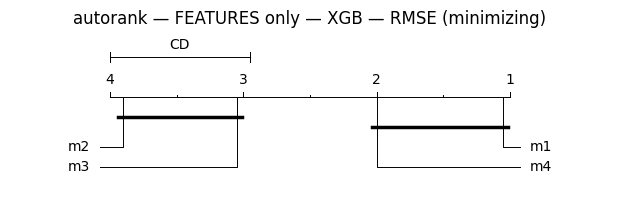

[LGBM RMSE] runs=20 × tratamentos=4 (m1, m2, m3, m4)
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column m1 (p=0.814166>=0.012500)
Fail to reject null hypothesis that data is normal for column m2 (p=0.770587>=0.012500)
Fail to reject null hypothesis that data is normal for column m3 (p=0.903876>=0.012500)
Fail to reject null hypothesis that data is normal for column m4 (p=0.609436>=0.012500)
Using Bartlett's test for homoscedacity of normally distributed data
Fail to reject null hypothesis that all variances are equal (p=0.914891>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
m

/tmp/ipython-input-529662784.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

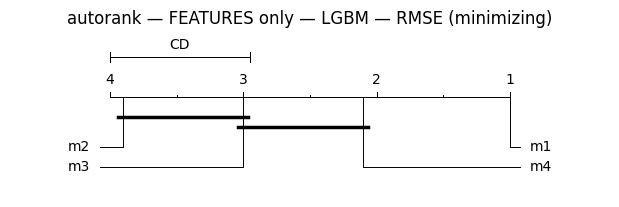

[MLP RMSE] runs=20 × tratamentos=4 (m1, m2, m3, m4)
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column m1 (p=0.999600>=0.012500)
Fail to reject null hypothesis that data is normal for column m2 (p=0.415776>=0.012500)
Fail to reject null hypothesis that data is normal for column m3 (p=0.536698>=0.012500)
Fail to reject null hypothesis that data is normal for column m4 (p=0.917432>=0.012500)
Using Bartlett's test for homoscedacity of normally distributed data
Fail to reject null hypothesis that all variances are equal (p=0.973332>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
m1

/tmp/ipython-input-529662784.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

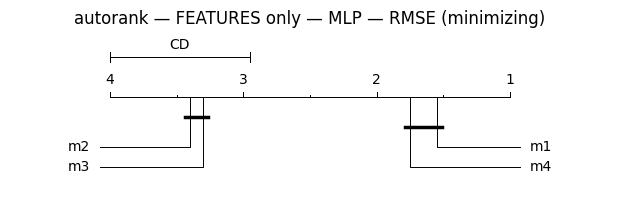

In [ ]:


import os
import io
import inspect
import contextlib
import pandas as pd
import matplotlib.pyplot as plt
from autorank import autorank, create_report, plot_stats

# ===================== CONFIG =====================
EXCEL_PATH = "Model_Results_BB_20_features.xlsx"  # ajuste se necessário
SHEET_NAME = "Sheet1"
MODELS     = ["RF", "XGB", "LGBM", "MLP"]

# Liste todas as features disponíveis e exclua as indesejadas:
ALL_FEATURES = [f"feature{i}" for i in range(1, 8)]  # ajuste o range conforme seu arquivo
EXCLUDE      = {"feature5", "feature6","feature7"}                      # <- desconsidere F5 (adicione mais se quiser)
FEATURES     = [f for f in ALL_FEATURES if f not in EXCLUDE]

METRICS    = ["MAE", "RMSE"]     # ambas minimizam
OUT_DIR    = "autorank_features_only_fixed"
os.makedirs(OUT_DIR, exist_ok=True)
# ==================================================

def _label_from_feature_name(f: str) -> str:
    """'feature6' -> 'M6' (mantém numeração original com 'M' em vez de 'F')."""
    return f"m{int(f.replace('feature', ''))}"  # M em vez de F

def capture_report_to_txt(stats, base_path: str) -> str:
    """Compatível com múltiplas versões do autorank: salva o report em .txt."""
    txt_path = f"{base_path}.txt"
    _ = inspect.signature(create_report)  # força import de assinatura
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        maybe_text = create_report(stats)
    text = maybe_text if isinstance(maybe_text, str) and maybe_text.strip() else buf.getvalue()
    if not text:
        text = "autorank.create_report() não retornou conteúdo nesta versão."
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(text)
    return txt_path

def autorank_minimize(mat: pd.DataFrame, alpha=0.05, verbose=True):
    """Garante minimização (menor = melhor) em diferentes versões do autorank."""
    try:
        return autorank(mat, alpha=alpha, verbose=verbose,
                        force_mode="nonparametric", maximize=False)
    except TypeError:
        return autorank(mat, alpha=alpha, verbose=verbose,
                        force_mode="nonparametric", order="ascending")

# ---------- (A) GLOBAL: blocos = (run, modelo); tratamentos = F{...} ----------
def build_matrix_features_global(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    records = []
    for _, row in df.iterrows():
        run_id = row["run"]
        for m in MODELS:
            row_dict, ok = {}, True
            for f in FEATURES:
                col = f"{f}_{metric}_{m}"
                if col not in df.columns or pd.isna(row[col]):
                    ok = False
                    break
                lbl = _label_from_feature_name(f)     # mantém F1..Fn originais
                row_dict[lbl] = float(row[col])
            if ok:
                records.append({"block": f"{run_id}_{m}", **row_dict})
    mat = pd.DataFrame(records).dropna(axis=0, how="any")
    mat = mat.drop_duplicates(subset=["block"]).set_index("block")
    return mat

# ---------- (B) POR MODELO: blocos = runs; tratamentos = F{...} ----------
def build_matrix_features_by_model(df: pd.DataFrame, metric: str, model: str) -> pd.DataFrame:
    rows = []
    for _, r in df.iterrows():
        run_id = r["run"]
        vals, ok = {}, True
        for f in FEATURES:
            col = f"{f}_{metric}_{model}"
            if col not in df.columns or pd.isna(r[col]):
                ok = False
                break
            lbl = _label_from_feature_name(f)
            vals[lbl] = float(r[col])
        if ok:
            rows.append({"run": run_id, **vals})
    mat = pd.DataFrame(rows).dropna(axis=0, how="any")
    mat = mat.drop_duplicates(subset=["run"]).set_index("run")
    return mat

def main():
    df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
    if "run" not in df.columns:
        raise ValueError("A coluna 'run' é obrigatória no arquivo.")

    for metric in METRICS:
        # ===== (A) GLOBAL =====
        matA = build_matrix_features_global(df, metric)
        if not matA.empty:
            print(f"[GLOBAL {metric}] blocos={matA.shape[0]} × tratamentos={matA.shape[1]} ({', '.join(matA.columns)})")
            matA.mean().sort_values().to_csv(
                os.path.join(OUT_DIR, f"means_GLOBAL_{metric}.csv"), header=[f"{metric}_mean"]
            )
            statsA = autorank_minimize(matA, alpha=0.05, verbose=True)
            repA = capture_report_to_txt(statsA, os.path.join(OUT_DIR, f"autorank_report_GLOBAL_{metric}"))
            print(f"[GLOBAL {metric}] relatório: {repA}")

            ranksA = getattr(statsA, "ranks", None)
            if ranksA is not None:
                ranksA.sort_values(inplace=True)
                ranksA.reset_index().rename(
                    columns={"index":"Feature", 0:"Average Rank (lower=better)"}
                ).to_csv(os.path.join(OUT_DIR, f"average_ranks_GLOBAL_{metric}.csv"), index=False)

            plt.figure()
            plot_stats(statsA)
            plt.title(f"autorank — FEATURES only (GLOBAL) — {metric} (minimizing)")
            plt.tight_layout()
            plt.savefig(os.path.join(OUT_DIR, f"autorank_FEATURES_GLOBAL_{metric}.png"), dpi=200)
            plt.show()

        # ===== (B) POR MODELO =====
        for m in MODELS:
            matB = build_matrix_features_by_model(df, metric, m)
            if matB.empty:
                continue
            print(f"[{m} {metric}] runs={matB.shape[0]} × tratamentos={matB.shape[1]} ({', '.join(matB.columns)})")
            matB.mean().sort_values().to_csv(
                os.path.join(OUT_DIR, f"means_{m}_{metric}.csv"), header=[f"{metric}_mean"]
            )
            statsB = autorank_minimize(matB, alpha=0.05, verbose=True)
            repB = capture_report_to_txt(statsB, os.path.join(OUT_DIR, f"autorank_report_{m}_{metric}"))
            print(f"[{m} {metric}] relatório: {repB}")

            ranksB = getattr(statsB, "ranks", None)
            if ranksB is not None:
                ranksB.sort_values(inplace=True)
                ranksB.reset_index().rename(
                    columns={"index":"Feature", 0:"Average Rank (lower=better)"}
                ).to_csv(os.path.join(OUT_DIR, f"average_ranks_{m}_{metric}.csv"), index=False)

            plt.figure()
            plot_stats(statsB)
            plt.title(f"autorank — FEATURES only — {m} — {metric} (minimizing)")
            plt.tight_layout()
            plt.savefig(os.path.join(OUT_DIR, f"autorank_FEATURES_{m}_{metric}.png"), dpi=200)
            plt.show()

if __name__ == "__main__":
    main()


[MAE] 20 runs × 16 tratamentos.
[MAE] médias por tratamento salvas em: autorank_out_min/means_MAE.csv
[MAE] TOP-5 (menor média):
XGB_m1     0.822534
LGBM_m1    0.830813
XGB_m4     0.846669
LGBM_m4    0.852620
XGB_m3     0.868431
dtype: float64

Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column RF_m1 (p=0.545398>=0.003125)
Fail to reject null hypothesis that data is normal for column RF_m2 (p=0.196569>=0.003125)
Fail to reject null hypothesis that data is normal for column RF_m3 (p=0.422876>=0.003125)
Fail to reject null hypothesis that data is normal for column RF_m4 (p=0.136114>=0.003125)
Fail to reject null hypothesis that data is normal for column XGB_m1 (p=0.502666>=0.003125)
Fail to reject null hypothesis that data is normal for column XGB_m2 (p=0.465012>=0.003125)
Fail to reject null hypothesis that data is normal for column XGB_m3 (p=0.787525>=0.003125)
Fail to reject nu

/tmp/ipython-input-3239392241.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

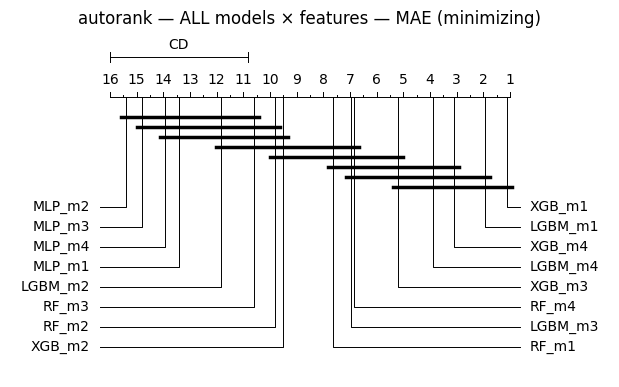

[MAE] figura salva em: autorank_out_min/autorank_MAE.png
[RMSE] 20 runs × 16 tratamentos.
[RMSE] médias por tratamento salvas em: autorank_out_min/means_RMSE.csv
[RMSE] TOP-5 (menor média):
XGB_m1     1.241453
LGBM_m1    1.246508
XGB_m4     1.263899
LGBM_m4    1.269184
RF_m4      1.285637
dtype: float64

Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column RF_m1 (p=0.740389>=0.003125)
Fail to reject null hypothesis that data is normal for column RF_m2 (p=0.651312>=0.003125)
Fail to reject null hypothesis that data is normal for column RF_m3 (p=0.916068>=0.003125)
Fail to reject null hypothesis that data is normal for column RF_m4 (p=0.460369>=0.003125)
Fail to reject null hypothesis that data is normal for column XGB_m1 (p=0.911362>=0.003125)
Fail to reject null hypothesis that data is normal for column XGB_m2 (p=0.945624>=0.003125)
Fail to reject null hypothesis that data is norm

/tmp/ipython-input-3239392241.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

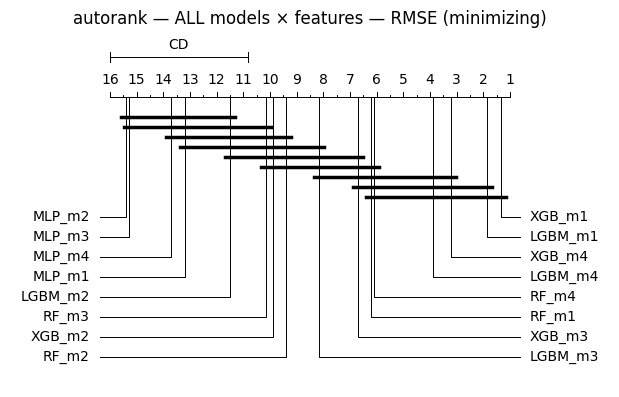

[RMSE] figura salva em: autorank_out_min/autorank_RMSE.png


In [ ]:
import os
import io
import inspect
import contextlib
import pandas as pd
import matplotlib.pyplot as plt
from autorank import autorank, create_report, plot_stats

# ============== CONFIG ==============
EXCEL_PATH = "Model_Results_BB_20_features.xlsx"   # ajuste se necessário
SHEET_NAME = "Sheet1"
MODELS     = ["RF", "XGB", "LGBM", "MLP"]
FEATURES   = [f"feature{i}" for i in range(1, 5)]  # feature1..feature4
METRICS    = ["MAE", "RMSE"]                        # ambas minimizam
OUT_DIR    = "autorank_out_min"
os.makedirs(OUT_DIR, exist_ok=True)
# ====================================

def build_matrix(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    """
    Monta matriz (linhas=runs, colunas=todos os tratamentos MODELO_Fi),
    mantendo apenas runs completos (sem NaN).
    """
    expected = [f"{f}_{metric}_{m}" for m in MODELS for f in FEATURES]
    missing = [c for c in expected if c not in df.columns]
    if missing:
        raise ValueError(f"Faltam colunas para {metric}: {missing[:6]}... (total {len(missing)})")

    records = {}
    for _, row in df.iterrows():
        run_id = row["run"]
        line = {}
        ok = True
        for m in MODELS:
            for f in FEATURES:
                col = f"{f}_{metric}_{m}"
                val = row[col]
                if pd.isna(val):
                    ok = False
                    break
                line[f"{m}_m{f.replace('feature','')}"] = float(val)
            if not ok:
                break
        if ok:
            records.setdefault(run_id, {}).update(line)

    mat = pd.DataFrame.from_dict(records, orient="index").sort_index()
    mat = mat.dropna(axis=0, how="any")
    return mat

def save_report_any_version(stats, base_path: str) -> str:
    """
    Salva o relatório do autorank de modo robusto a versões:
    - Se create_report(stats) retornar string, salva .txt.
    - Caso contrário, captura stdout do create_report(stats) e salva .txt.
    """
    txt_path = f"{base_path}.txt"
    _ = inspect.signature(create_report)  # apenas para provocar import/checar assinatura
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        maybe_text = create_report(stats)
    text = maybe_text if isinstance(maybe_text, str) and maybe_text.strip() else buf.getvalue()
    if not text:
        text = "autorank.create_report() não retornou conteúdo nesta versão."
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(text)
    return txt_path

def run_autorank_minimize(mat: pd.DataFrame, alpha=0.05, verbose=True):
    """
    Executa autorank garantindo minimização (menor = melhor),
    lidando com diferenças de versão (maximize vs order='ascending').
    """
    try:
        # versões recentes aceitam maximize=
        stats = autorank(mat, alpha=alpha, verbose=verbose,
                         force_mode="nonparametric", maximize=False)
    except TypeError:
        # fallback: versões que usam 'order'
        stats = autorank(mat, alpha=alpha, verbose=verbose,
                         force_mode="nonparametric", order="ascending")
    return stats

def main():
    df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
    if "run" not in df.columns:
        raise ValueError("A coluna 'run' é obrigatória.")

    for metric in METRICS:
        mat = build_matrix(df, metric)
        if mat.empty:
            print(f"[{metric}] matriz vazia após filtro de completude.")
            continue

        print(f"[{metric}] {mat.shape[0]} runs × {mat.shape[1]} tratamentos.")
        # Checagem rápida: menores médias devem ser melhores
        means_sorted = mat.mean().sort_values()   # menor = melhor
        means_csv = os.path.join(OUT_DIR, f"means_{metric}.csv")
        means_sorted.to_csv(means_csv, header=[f"{metric}_mean"])
        print(f"[{metric}] médias por tratamento salvas em: {means_csv}")
        print(f"[{metric}] TOP-5 (menor média):\n{means_sorted.head(5)}\n")

        # autorank minimizando a métrica
        stats = run_autorank_minimize(mat, alpha=0.05, verbose=True)

        # relatório (compatível com várias versões)
        base = os.path.join(OUT_DIR, f"autorank_report_{metric}")
        rep_path = save_report_any_version(stats, base)
        print(f"[{metric}] relatório salvo em: {rep_path}")

        # exporta ranks médios (se disponível)
        ranks = getattr(stats, "ranks", None)
        if ranks is not None:
            ranks = ranks.sort_values()  # menor rank = melhor
            ranks_df = ranks.reset_index()
            ranks_df.columns = ["Treatment", "Average Rank (lower=better)"]
            ranks_csv = os.path.join(OUT_DIR, f"average_ranks_{metric}.csv")
            ranks_df.to_csv(ranks_csv, index=False)
            print(f"[{metric}] average ranks salvos em: {ranks_csv}")

        # Gráfico com CD diagram (inclui resumo/boxplots padrão do autorank)
        plt.figure()
        plot_stats(stats)
        plt.title(f"autorank — ALL models × features — {metric} (minimizing)")
        fig_path = os.path.join(OUT_DIR, f"autorank_{metric}.png")
        plt.tight_layout()
        plt.savefig(fig_path, dpi=200)
        plt.show()
        print(f"[{metric}] figura salva em: {fig_path}")

if __name__ == "__main__":
    main()


#garficos

# %% Colab: Viewer dinâmico para series_*.csv (dropdown + zoom + salvar)
from pathlib import Path
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import ipywidgets as w
from IPython.display import display, clear_output

# ---------- mapeamento de nomes bonitos ----------
PRETTY_METHOD = {

    "full_conformal":     "Full Conformal",
    "split_conformal":    "Split Conformal",
    "bootstrap_f": "Bootstrap",
    "cqr_xgb":            "CQR",
    "enbpi_xgb":          "EnbPI",
}

def _parse_series_filename(path: Path):
    """
    Espera: series_{METHOD}_{SPLIT}_{MODEL}.csv
    METHOD pode ter underscores (ex.: enbpi_rf_f). SPLIT/MODEL não.
    """
    stem = path.stem
    if not stem.startswith("series_"):
        return None, None, None
    tail = stem[len("series_"):]
    try:
        method, split, model = tail.rsplit("_", 2)
    except ValueError:
        method, split, model = tail, "unknown", "unknown"
    return method, split, model

# --------- temas de cor (real, predito, fill, contorno) ---------
PASTEL_F = {
    "F1_blue":  "#9ecae1",
    "F2_orange":"#fdbb84",
    "F3_green": "#a1d99b",
    "F4_pink":  "#fcaeae",
}
DARK = {"green": "#74c476", "grey": "#9e9e9e"}

THEMES = {
    "Paper (blue/red/green)": ("#1f77b4", "#d62728", "#ccebc5", "#66a61e"),
    "F1-F2-F3 (pastel)": (PASTEL_F["F1_blue"], PASTEL_F["F2_orange"], PASTEL_F["F3_green"], DARK["green"]),
    "F1-F4-F3 (pastel)": (PASTEL_F["F1_blue"], PASTEL_F["F4_pink"],   PASTEL_F["F3_green"], DARK["green"]),
    "Grey interval (pastel)": (PASTEL_F["F1_blue"], PASTEL_F["F2_orange"], "#e6e6e6", DARK["grey"]),
}

def _interval_label(method: str, lang: str = "pt") -> str:
    m = (method or "").lower()
    base_pt = {
        "bootstrap":       "Intervalo de Predição (Bootstrap)",
        "split_conformal": "Intervalo de Predição (Split Conformal)",
        "full_conformal":  "Intervalo de Predição (Full Conformal)",
        "t_student":       "Intervalo de Predição (t-Student)",
        "cqr":             "Intervalo de Predição (CQR)",
    }
    base_en = {
        "bootstrap":       "Prediction Interval (Bootstrap)",
        "split_conformal": "Prediction Interval (Split Conformal)",
        "full_conformal":  "Prediction Interval (Full Conformal)",
        "t_student":       "Prediction Interval (t-Student)",
        "cqr":             "Prediction Interval (CQR)",
    }
    base = base_pt if lang == "pt" else base_en
    return base.get(m, f"Intervalo de Predição ({method})" if lang=="pt" else f"Prediction Interval ")
    # return base.get(m, f"Intervalo de Predição ({method})" if lang=="pt" else f"Prediction Interval ({method})")

def _title_from_filename(p: Path, alpha=None):
    method, split, model = _parse_series_filename(p)
    pretty = PRETTY_METHOD.get(method, method or "method?")
    extra = []
    if split: extra.append(f"split={split}")
    if model: extra.append(f"model={model}")
    if alpha is not None: extra.append(f"α={alpha:.2f}")
    return method, f"{pretty} | " + " | ".join(extra)

def _initial_y_limits(y_true, y_pred, lower, upper):
    y_all = np.concatenate([y_true, y_pred, lower, upper])
    yq1, yq99 = np.nanpercentile(y_all, [1, 99])
    if not np.isfinite(yq1): yq1 = np.nanmin(y_all)
    if not np.isfinite(yq99): yq99 = np.nanmax(y_all)
    pad = 0.05 * max(yq99 - yq1, 1e-6)
    return float(yq1 - pad), float(yq99 + pad)

def make_series_viewer(series_dir="/content", alpha=None):
    series_dir = Path(series_dir)
    csvs = sorted(series_dir.glob("series_*.csv"))
    if not csvs:
        print(f"[WARN] Nenhum 'series_*.csv' encontrado em {series_dir.resolve()}")
        return

    # opções do dropdown com rótulo bonitinho
    options = []
    for p in csvs:
        method, split, model = _parse_series_filename(p)
        pretty = PRETTY_METHOD.get(method, method or "method?")
        label = f"{pretty} — split={split} — model={model} ({p.name})"
        options.append((label, str(p)))

    # widgets
    dd_file   = w.Dropdown(description="arquivo", options=options, value=str(csvs[0]), layout=w.Layout(width="95%"))
    dd_theme  = w.Dropdown(description="tema", options=list(THEMES.keys()), value="Paper (blue/red/green)")

    # placeholders (ajustados quando o arquivo muda)
    s_start   = w.IntSlider(description="start", min=0, max=100, step=10, value=0, continuous_update=False)
    s_window  = w.IntSlider(description="window", min=50, max=1000, step=10, value=300, continuous_update=False)
    s_alpha   = w.FloatSlider(description="fill α", min=0.15, max=0.60, step=0.02, value=0.30, readout_format=".2f")
    s_edge    = w.FloatSlider(description="borda", min=0.6, max=2.5, step=0.1, value=1.2, readout_format=".1f")
    dd_legend = w.Dropdown(description="legenda", options=[("Português","pt"),("English","en")], value="pt")
    dd_legloc = w.Dropdown(description="leg loc",
                           options=["best","upper left","upper right","lower left","lower right","center"],
                           value="best")

    r_autoY  = w.Button(description="Auto Y-limits", icon="magic")
    r_save   = w.Button(description="Salvar PNG", icon="save")
    lab_info = w.HTML()

    y_min = w.FloatText(description="Y min", step=0.01)
    y_max = w.FloatText(description="Y max", step=0.01)

    out = w.Output()

    # cache simples para evitar reler sempre
    _cache = {}
    def _load(path_str):
        if path_str in _cache:
            return _cache[path_str]
        df = pd.read_csv(path_str)
        data = dict(
            y_true=df["y_true"].values,
            y_pred=df["y_pred"].values,
            lower=df["lower"].values,
            upper=df["upper"].values
        )
        _cache[path_str] = data
        return data

    def _sync_sliders_for_file(path_str):
        data = _load(path_str)
        n = len(data["y_true"])
        # ajustar ranges
        s_window.max = max(n, 1)
        s_window.min = min(50, max(1, n//20))
        s_window.step = max(1, n//200)
        s_window.value = min(300, n)

        s_start.max = max(0, n - s_window.value)
        s_start.min = 0
        s_start.step = max(1, n//200)
        s_start.value = 0

        ymin, ymax = _initial_y_limits(**data)
        y_min.value = round(ymin, 4)
        y_max.value = round(ymax, 4)

        method, title = _title_from_filename(Path(path_str), alpha=alpha)
        lab_info.value = f"<b>{title}</b> &nbsp;|&nbsp; n={n}"

    def _plot_current(*args):
        path_str = dd_file.value
        data = _load(path_str)
        y_true, y_pred, lower, upper = data["y_true"], data["y_pred"], data["lower"], data["upper"]
        n = len(y_true)

        # manter coerência start/window
        s_start.max = max(0, n - s_window.value)
        start = min(s_start.value, s_start.max)
        end = min(n, start + s_window.value)
        xi = np.arange(start, end) - start

        real_c, pred_c, fill_c, edge_c = THEMES[dd_theme.value]

        with out:
            clear_output(wait=True)
            fig, ax = plt.subplots(figsize=(12, 4), dpi=150)
            ax.plot(xi, y_true[start:end], lw=2.2, color=real_c, label="Reais")
            ax.plot(xi, y_pred[start:end], lw=1.9, color=pred_c, label="Preditos")
            poly = ax.fill_between(xi, lower[start:end], upper[start:end],
                                   color=fill_c, alpha=float(s_alpha.value))
            poly.set_edgecolor(edge_c)
            poly.set_linewidth(float(s_edge.value))

            # y-limits
            ymin, ymax = float(y_min.value), float(y_max.value)
            if ymin < ymax:
                ax.set_ylim((ymin, ymax))

            # ax.set_xlabel("Índice (tempo)")
            ax.set_ylabel("SiO₂ in concentrate (%)")
            method, title = _title_from_filename(Path(path_str), alpha=alpha)
            # ax.set_title(title)
            ax.grid(axis="y", linestyle="--", alpha=0.18)

            handles = [
                Line2D([0],[0], color=real_c, lw=2.2, label="Valores Reais" if dd_legend.value=="pt" else "True Values"),
                Line2D([0],[0], color=pred_c, lw=1.9, label="Predições" if dd_legend.value=="pt" else "Predictions"),
                Patch(facecolor=fill_c, edgecolor=edge_c, linewidth=float(s_edge.value),
                      alpha=float(s_alpha.value), hatch="////",
                      label=_interval_label(method, dd_legend.value)),
            ]
            ax.legend(handles=handles, frameon=True, loc=dd_legloc.value)
            fig.tight_layout()
            plt.show()

    def _auto_y(*args):
        data = _load(dd_file.value)
        ymin, ymax = _initial_y_limits(**data)
        y_min.value = round(ymin, 4)
        y_max.value = round(ymax, 4)
        _plot_current()
    def _save_pdf(*args):
        p = Path(dd_file.value)
        out_pdf = p.with_name(f"interval_{p.stem[len('series_'):]}.viewer.pdf")

        # redesenha a figura para salvar (igual ao PNG)
        data = _load(dd_file.value)
        y_true, y_pred, lower, upper = data["y_true"], data["y_pred"], data["lower"], data["upper"]
        n = len(y_true)
        start = int(s_start.value); end = min(n, start + int(s_window.value))
        xi = np.arange(start, end) - start
        real_c, pred_c, fill_c, edge_c = THEMES[dd_theme.value]

        fig, ax = plt.subplots(figsize=(12, 4), dpi=150)
        ax.plot(xi, y_true[start:end], lw=2.2, color=real_c)
        ax.plot(xi, y_pred[start:end], lw=1.9, color=pred_c)
        poly = ax.fill_between(xi, lower[start:end], upper[start:end], color=fill_c, alpha=float(s_alpha.value))
        poly.set_edgecolor(edge_c); poly.set_linewidth(float(s_edge.value))

        ymin, ymax = float(y_min.value), float(y_max.value)
        if ymin < ymax: ax.set_ylim((ymin, ymax))

        # (opcional) título conforme seu checkbox
        _, title = _title_from_filename(Path(dd_file.value), alpha=alpha)
        # ax.set_title(title)  # use se quiser título no PDF

        # ax.set_xlabel("Time Step (s)")
        ax.set_ylabel("SiO₂ no concentrado (%)")
        ax.grid(axis="y", linestyle="--", alpha=0.18)
        fig.tight_layout()

        # PDF é vetorial — não precisa de dpi
        fig.savefig(out_pdf, bbox_inches="tight", format="pdf")  # <- aqui muda
        plt.close(fig)
        lab_info.value = f"{lab_info.value} &nbsp;|&nbsp; <span style='color:green'>salvo: {out_pdf.name}</span>"

    def _save_png(*args):
        p = Path(dd_file.value)
        out_png = p.with_name(f"interval_{p.stem[len('series_'):]}.viewer.png")
        # desenha novamente em figura própria para salvar
        data = _load(dd_file.value)
        y_true, y_pred, lower, upper = data["y_true"], data["y_pred"], data["lower"], data["upper"]
        n = len(y_true)
        start = int(s_start.value); end = min(n, start + int(s_window.value))
        xi = np.arange(start, end) - start
        real_c, pred_c, fill_c, edge_c = THEMES[dd_theme.value]

        fig, ax = plt.subplots(figsize=(12, 4), dpi=150)
        ax.plot(xi, y_true[start:end], lw=2.2, color=real_c)
        ax.plot(xi, y_pred[start:end], lw=1.9, color=pred_c)
        poly = ax.fill_between(xi, lower[start:end], upper[start:end],
                               color=fill_c, alpha=float(s_alpha.value))
        poly.set_edgecolor(edge_c); poly.set_linewidth(float(s_edge.value))
        ymin, ymax = float(y_min.value), float(y_max.value)
        if ymin < ymax: ax.set_ylim((ymin, ymax))
        _, title = _title_from_filename(Path(dd_file.value), alpha=alpha)
        # ax.set_title(title); ax.set_xlabel("Time Step (h)"); ax.set_ylabel("SiO₂ no concentrado (%)")
        ax.grid(axis="y", linestyle="--", alpha=0.18)
        fig.tight_layout()
        fig.savefig(out_png, bbox_inches="tight", dpi=200)
        plt.close(fig)
        lab_info.value = f"{lab_info.value} &nbsp;|&nbsp; <span style='color:green'>salvo: {out_png.name}</span>"

    # liga eventos
    dd_file.observe(lambda ch: _sync_sliders_for_file(ch["new"]) or _plot_current(), names="value")
    s_window.observe(lambda ch: _plot_current(), names="value")
    s_start.observe(lambda ch: _plot_current(), names="value")
    dd_theme.observe(lambda ch: _plot_current(), names="value")
    s_alpha.observe(lambda ch: _plot_current(), names="value")
    s_edge.observe(lambda ch: _plot_current(), names="value")
    dd_legend.observe(lambda ch: _plot_current(), names="value")
    dd_legloc.observe(lambda ch: _plot_current(), names="value")
    y_min.observe(lambda ch: _plot_current(), names="value")
    y_max.observe(lambda ch: _plot_current(), names="value")
    r_autoY.on_click(_auto_y)
    r_save.on_click(_save_png)

    # layout bonitinho
    row1 = w.HBox([dd_file])
    row2 = w.HBox([dd_theme, s_alpha, s_edge, dd_legend, dd_legloc])
    row3 = w.HBox([s_start, s_window, y_min, y_max, r_autoY, r_save])
    ui = w.VBox([row1, row2, row3, lab_info, out])

    # init
    _sync_sliders_for_file(dd_file.value)
    _plot_current()
    display(ui)




In [ ]:
make_series_viewer("/content/drive/MyDrive/artigoI2MTC2026/results")